# Clustering Urban Mobility Features in Utrecht with HDBSCAN + UMAP

This notebook performs unsupervised clustering on Utrecht's hex-based spatial features using UMAP for dimensionality reduction and HDBSCAN for clustering. The objective is to identify areas with similar mobility profiles based on access to transport, job concentration, housing growth, and planned infrastructure.

---

## Workflow Overview

**Main steps:**
1. Load and prepare spatial feature data
2. Normalize and scale selected variables
3. Reduce dimensionality using UMAP
4. Apply HDBSCAN with different configurations
5. Evaluate cluster quality (silhouette score, noise percentage)
6. Visualize spatial patterns and interpret results

---

## 1. Feature Set Used for Clustering

| Feature Name                     | Description                                                                 |
|----------------------------------|-----------------------------------------------------------------------------|
| `log_vehicle_availability`       | Log-transformed average availability of shared vehicles (bikes, cars, cargo) |
| `has_ovfiets_access`            | Binary flag indicating access to OVFiets within a defined radius            |
| `hub_distance_score`            | Score representing proximity to existing mobility hubs                      |
| `hub_overall_score`             | Composite score summarizing hub quality and accessibility                   |
| `pt_line_distance`              | Distance to the nearest public transport line (bus or rail)                 |
| `pt_access_score`               | Accessibility score based on public transport frequency and proximity       |
| `job_weighted_log`              | Log-transformed weighted job concentration per hex                          |
| `planned_housing_units_log`     | Log of housing units planned for development                                |
| `planned_density_score_log`     | Log-transformed density of planned housing developments                     |
| `absolute_growth_utrecht_2025_flag` | Binary flag for high expected housing growth areas by 2025               |
| `housing_density_utrecht_2025_flag` | Binary flag for areas with high 2025 housing density                     |

> ℹ️ `hex_id` and `geometry` were excluded from clustering and used only for spatial indexing and joins.


---

## 2. Methods and Tools

- **Libraries**:
  - `geopandas` – for working with geospatial data.
  - `scikit-learn` – for feature scaling and pipeline tools.
  - `hdbscan` – for clustering using a hierarchical density-based approach.
  - `matplotlib` / `contextily` – for plotting spatial results.

- **Scaling Techniques**:
  - Either `StandardScaler` or `MinMaxScaler` was used depending on feature distribution.

- **Dimensionality Reduction**:
  - UMAP was used to reduce the feature space to two dimensions prior to clustering, enabling better separation and visualization.

- **Clustering**:
  - HDBSCAN was applied iteratively with different `min_cluster_size` parameters to evaluate stability and cluster formation.

- **Evaluation Metrics**:
  - Cluster quality was assessed using silhouette scores and the percentage of noise points (unclustered data).

- **Visualization**:
  - Cluster outputs were mapped back onto the hex grid to interpret spatial patterns and identify meaningful groupings.

---

This notebook provides a comprehensive clustering analysis of urban mobility conditions in Utrecht. The resulting clusters help to uncover spatial patterns in mobility infrastructure, housing development, and accessibility, which can guide future hub planning.



## 1. Data Preparation  

In [1]:
# Imports
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import hdbscan
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
from config import QGIS_DIR

# Read the file from the "Final" subfolder inside 1.3QGIS DIR
utrecht_mobility = gpd.read_file(
    QGIS_DIR / "hex_all_features_final_fixes.gpkg")
# Config / Paths
from config import QGIS_DIR

Project root directory: c:\Users\manoe.MC_ASUS\Documents\Utrecht-Mobility-Analysis\2.0_notebooks\..
Output directory is set to: c:\Users\manoe.MC_ASUS\Documents\Utrecht-Mobility-Analysis\2.0_notebooks\..\2.0_notebooks\0.0_outputs


In [2]:
utrecht_mobility.columns

Index(['hex_id', 'log_vehicle_availability', 'has_ovfiets_access',
       'hub_distance_score', 'hub_overall_score', 'pt_line_distance',
       'pt_access_score', 'job_weighted_log', 'planned_housing_units_log',
       'planned_density_score_log', 'absolute_growth_utrecht_2025_flag',
       'housing_density_utrecht_2025_flag', 'geometry'],
      dtype='object')

#### Defining the feature sets

In [3]:
# Define the feature sets
feature_sets = {
    "Housing and Jobs-Urban Demand": [
        "job_weighted_log",
        "planned_housing_units_log",
        "hub_overall_score",
        "pt_line_distance"
    ],
    "Accessibility & Supply-Infrastructure & Access": [
        "hub_distance_score",
        "pt_line_distance",
        "log_vehicle_availability",
        "has_ovfiets_access"        
    ],
    "Combined (Core)-Balanced Insight": [
        "job_weighted_log",                    
        "planned_density_score_log",           
        "log_vehicle_availability",                       
        "pt_access_score",                 
        "hub_overall_score"               
    ]
}

# Check if any columns in the feature sets do not exist in the dataframe
all_columns = set(utrecht_mobility.columns)
for set_name, features in feature_sets.items():
    missing = [col for col in features if col not in all_columns]
    if missing:
        print(f"Warning: The following columns in '{set_name}' do not exist in the dataframe: {missing}")

# Prepare an empty list to collect results
test_1_results = []


#### Functions to run the sets

In [4]:
def cluster_and_plot_geospatial(
    gdf, features, set_name="Unnamed Set",
    min_cluster_size=20, min_samples=None,
    save_column="cluster_label",
    cmap="nipy_spectral"
):
    """
    Applies HDBSCAN to geospatial features and plots the result over a real map,
    with a colorbar and cluster labels as C1 (count), ... and 'Non-clustered (count)' for noise.
    Features are scaled using RobustScaler.
    Always shows all cluster labels in a tall, readable colorbar.
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    from sklearn.preprocessing import RobustScaler
    from sklearn.metrics import silhouette_score
    import hdbscan

    gdf = gdf.copy()
    X = gdf[features]
    if X.isnull().any().any():
        raise ValueError("Input data contains NaNs. Please clean your data before clustering.")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples
    )
    labels = clusterer.fit_predict(X_scaled)
    gdf[save_column] = labels

    # Count the number of cells in each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_map = {}
    c_idx = 1
    for lab, count in zip(unique_labels, counts):
        if lab == -1:
            cluster_map[lab] = f"Non-clustered ({count})"
        else:
            cluster_map[lab] = f"C{c_idx} ({count})"
            c_idx += 1
    gdf["cluster_name"] = gdf[save_column].map(cluster_map)

    # For colorbar: create a column with integer codes for clusters (noise as last)
    max_cluster = np.max(unique_labels[unique_labels != -1]) if np.any(unique_labels != -1) else 0
    color_code = gdf[save_column].apply(lambda x: max_cluster + 1 if x == -1 else x)
    gdf["color_code"] = color_code

    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(labels).count(-1)
    sil_score = silhouette_score(X_scaled, labels) if n_clusters > 1 else -1

    # Plot: dynamically scale height for many clusters
    fig_height = max(12, len(unique_labels) * 0.3)
    fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    n_colors = n_clusters + 1
    cmap_obj = plt.get_cmap(cmap, n_colors)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, n_colors+0.5, 1), ncolors=n_colors)

    gdf.plot(
        column="color_code",
        cmap=cmap_obj,
        legend=False,
        ax=ax,
        edgecolor='white' if gdf.geometry.geom_type.iloc[0] in ["Polygon", "MultiPolygon"] else None,
        linewidth=0.05 if gdf.geometry.geom_type.iloc[0] in ["Polygon", "MultiPolygon"] else 1,
        norm=norm
    )
    # Colorbar with all cluster labels
    sm = plt.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
    sm._A = []
    if -1 in unique_labels:
        tick_labs = [cluster_map[lab] for lab in unique_labels if lab != -1] + [cluster_map[-1]]
    else:
        tick_labs = [cluster_map[lab] for lab in unique_labels]
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_ticks(np.arange(len(tick_labs)))
    cbar.set_ticklabels(tick_labs)
    # Dynamically adjust label size for many clusters
    labelsize = 12 if len(tick_labs) <= 30 else max(6, int(360 / len(tick_labs)))
    cbar.ax.tick_params(labelsize=labelsize)
    # Optionally, rotate labels for even more space
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(0)  # 0 for horizontal, 45 for diagonal

    ax.set_title(
        f"HDBSCAN – {set_name}\n"
        f"Clusters: {n_clusters} | Noise: {n_noise / len(gdf):.2%} | Silhouette: {sil_score:.3f}",
        fontsize=14
    )
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    return gdf, labels


In [5]:
def generate_cluster_summary(test_1, features, set_name, cluster_column="cluster_label"):
    """
    Generate summary statistics for clusters including means of features and hex counts.
    
    Args:
        test_1 (GeoDataFrame): The geodataframe containing cluster results
        features (list): List of feature columns to calculate means for
        set_name (str): Name of the feature set being analyzed
        cluster_column (str): Name of column containing cluster labels
        
    Returns:
        DataFrame: Summary statistics for each cluster
    """
    # Group by cluster and calculate mean for each feature
    cluster_stats = (
        test_1.groupby(cluster_column)[features]
        .mean()
        .round(2)
    )

    # Display number of hexes per cluster
    cluster_counts = test_1[cluster_column].value_counts()

    # Merge stats and counts
    cluster_summary = cluster_stats.copy()
    cluster_summary["hex_count"] = cluster_counts

    # Relabel the index
    cluster_summary.index = cluster_summary.index.map(lambda x: 'Non-clustered' if x == -1 else f'C{x+1}')

    # Reorder so "Non-clustered" is last
    if 'Non-clustered' in cluster_summary.index:
        cluster_summary = cluster_summary.drop('Non-clustered').sort_index()
        cluster_summary = pd.concat([cluster_summary, cluster_stats.loc[[-1]].rename(index={-1: 'Non-clustered'})])

    # Sort the cluster summary by index in ascending order
    cluster_summary = cluster_summary.sort_index()

    # Display as a table
    display(cluster_summary)
    
    return cluster_summary


## 2. Clustering (HDBSCAN) 
### Test 1

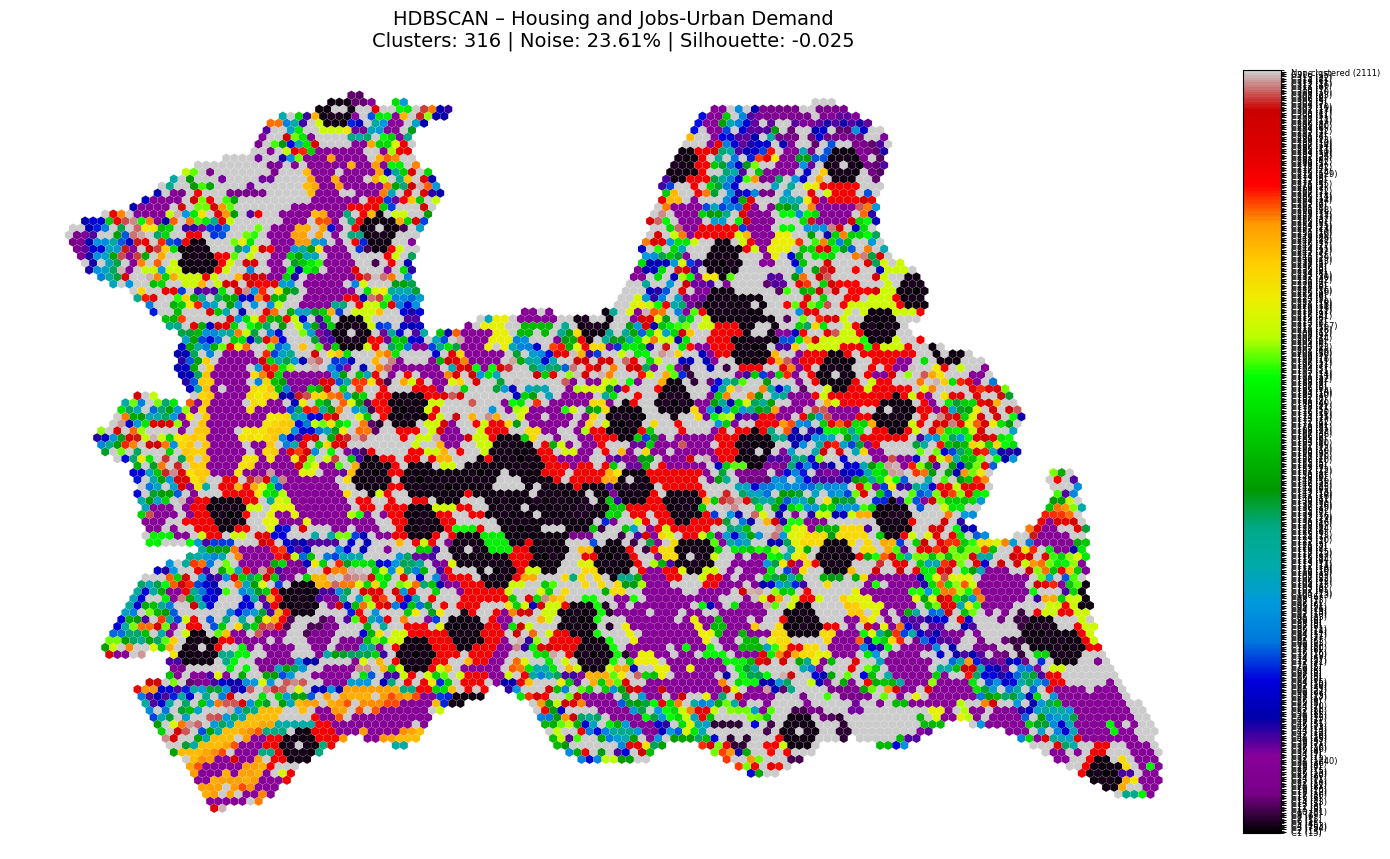

In [6]:
import numpy as np  

# Run just one feature set at a time
set_name = "Housing and Jobs-Urban Demand"  # Change this to the set you want to run
features = feature_sets[set_name]

# Ensure all input data is finite (replace inf/-inf with nan, then fill nan with 0)
# Note: 'force_all_finite' was renamed to 'ensure_all_finite' in scikit-learn 1.6
# This code ensures all values are finite for compatibility with newer scikit-learn
X = utrecht_mobility[features].replace([np.inf, -np.inf], np.nan).fillna(0)

# Process the selected feature set
gdf_result, labels_result = cluster_and_plot_geospatial(
    utrecht_mobility.assign(**{f: X[f] for f in features}),  # use cleaned data for clustering
    features,
    set_name=set_name,
    min_cluster_size=5,
    min_samples=5
)
gdf_result = gdf_result.copy()
gdf_result["feature_sets"] = set_name  # Add a column to identify the feature set
test_1_results.append(gdf_result)

# When done, concatenate all results into one GeoDataFrame
test_1 = gpd.GeoDataFrame(pd.concat(test_1_results, ignore_index=True))


## 3. Dimensionality Reduction (UMAP)

'''
The dataset contains multiple spatial and infrastructural features, many of which are correlated. Clustering directly on high-dimensional data can be noisy, unstable, and computationally expensive.

To address this, we apply **UMAP (Uniform Manifold Approximation and Projection)** — a non-linear dimensionality reduction technique that:

- Preserves both **local** and **global structure** of the data,
- Projects high-dimensional features into a **2D space** for easier clustering and visualization,
- Maintains **meaningful distances** between points (unlike PCA, which focuses on variance),
- Handles mixed feature types (binary + continuous) effectively after scaling.

By reducing the input space to two dimensions, UMAP simplifies the clustering task for HDBSCAN while still preserving spatially meaningful patterns in the data.

> UMAP is particularly well-suited for this project because the features capture urban mobility conditions with non-linear relationships that benefit from manifold-based mapping. ''


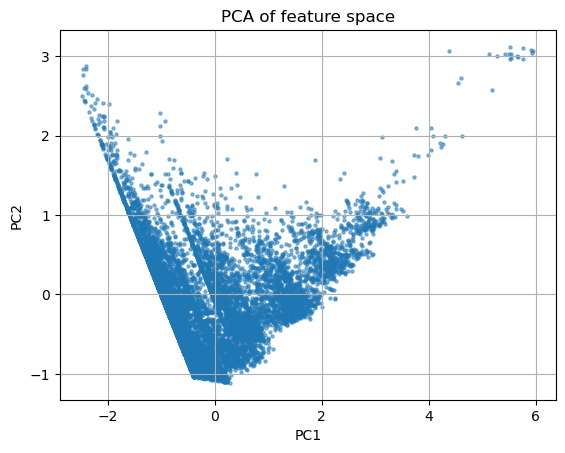

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = RobustScaler().fit_transform(utrecht_mobility[features].fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.5)
plt.title("PCA of feature space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [8]:
# Analysing all the features used among the feature sets
selected_features = [
    "job_weighted_log",
    "planned_housing_units_log",
    "hub_overall_score",
    "pt_line_distance",
    "hub_distance_score",
    "log_vehicle_availability",
    "has_ovfiets_access", 
    "planned_density_score_log"
]

# Now check the value distribution of each feature
for col in selected_features:
    print(f"Column: {col}")
    print(utrecht_mobility[col].value_counts().head(10))
    print("-" * 50)


Column: job_weighted_log
job_weighted_log
0.000000    2743
0.693147     842
1.098612     612
1.386294     485
1.609438     362
1.791759     280
2.079442     200
1.945910     186
2.197225     144
2.302585     117
Name: count, dtype: int64
--------------------------------------------------
Column: planned_housing_units_log
planned_housing_units_log
0.000000    4722
2.944439     323
0.693147     282
2.708050     244
1.098612     231
1.609438     199
1.386294     179
2.079442     164
3.044522     100
6.331502      77
Name: count, dtype: int64
--------------------------------------------------
Column: hub_overall_score
hub_overall_score
2    5757
3    2162
4     754
5     225
9      17
7      15
6       7
8       3
Name: count, dtype: int64
--------------------------------------------------
Column: pt_line_distance
pt_line_distance
1446.493324    1
3221.007621    1
2961.972204    1
2845.994705    1
2724.472340    1
2819.915837    1
2507.488020    1
2532.566983    1
2471.596466    1
2333.351

In [9]:
import hdbscan
import umap.umap_ as umap
from sklearn.preprocessing import RobustScaler
import numpy as np

# Define the features to use
features = [
    "job_weighted_log",
    "planned_housing_units_log",
    "hub_overall_score",
]

# Scale the data
X_scaled = RobustScaler().fit_transform(utrecht_mobility[features].fillna(0))

# Fit UMAP with updated parameters to avoid warnings about n_jobs and random_state
# UMAP >=0.5.4: n_jobs is ignored if random_state is set, so we do not set n_jobs
umap_embedder = umap.UMAP(random_state=42)
X_umap = umap_embedder.fit_transform(X_scaled)

# Run HDBSCAN on UMAP-reduced data

clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
labels = clusterer.fit_predict(X_umap)

# Summary
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_pct = np.mean(labels == -1)

print(f"Clusters found: {n_clusters}")
print(f"Noise %: {noise_pct:.2%}")

Clusters found: 160
Noise %: 4.04%


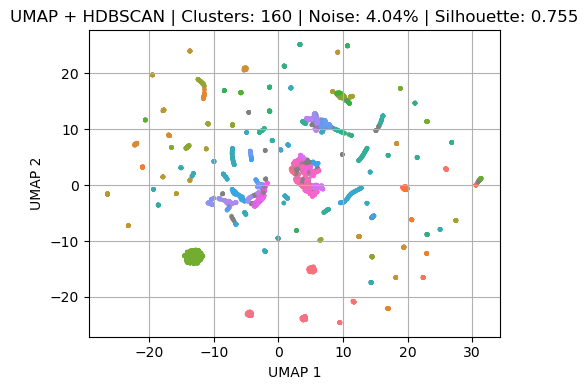

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

# Fit UMAP
X_scaled = RobustScaler().fit_transform(utrecht_mobility[features].fillna(0))
X_umap = umap.UMAP(random_state=42).fit_transform(X_scaled)

# Step 1: Assign cluster labels
utrecht_mobility["umap_cluster"] = labels

# Step 2: Generate color palette (add 1 if there's noise cluster -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
palette = sns.color_palette("husl", n_clusters)
colors = [palette[label] if label != -1 else (0.5, 0.5, 0.5) for label in labels]

# Step 2.5: Compute silhouette score (only if more than 1 cluster and not all noise)
if n_clusters > 1 and np.any(labels != -1):
    # Only use non-noise points for silhouette score
    mask = labels != -1
    sil_score = silhouette_score(X_umap[mask], np.array(labels)[mask])
else:
    sil_score = float('nan')

# Step 3: Plot
plt.figure(figsize=(5, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, s=5, alpha=0.6)
plt.title(f"UMAP + HDBSCAN | Clusters: {n_clusters} | Noise: {noise_pct:.2%} | Silhouette: {sil_score:.3f}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.tight_layout()
plt.show()


UMAP allowed us to:
- Reduce dimensionality while preserving both local and global structure.
- Visualize the clustering potential of the data before applying HDBSCAN.
- Diagnose how different features contribute to spatial differentiation across Utrecht.



----------------------------------------------------------------------------------------

## 4. Batch UMAP + HDBSCAN Analysis Across Thematic Feature Sets

To understand how different mobility and development themes affect cluster formation, we ran UMAP and HDBSCAN iteratively on separate feature groups:


- **Housing and Jobs – Urban Demand**
- **First and Last Mile Need Zones**
- **Access to Infrastructure**

Each configuration includes:
- Feature scaling with `RobustScaler` (resistant to outliers),
- Dimensionality reduction via UMAP (2D embedding),
- Clustering with HDBSCAN (`min_cluster_size=15`),
- Spatial visualization with thematic legends,
- Cluster-wise summaries showing average feature values.

This modular structure allows us to compare how different variables drive spatial differentiation in Utrecht’s urban fabric and mobility infrastructure.

In [11]:
# Redefine the feature sets
# --- FEATURE SETS FOR CLUSTERING ---
feature_sets = {
    # === HOUSING AND JOBS - URBAN DEMAND ===
    "Housing and Jobs-Urban Demand": [
        "job_weighted_log",            # demand: weighted jobs
        "planned_housing_units_log",   # demand: planned housing units
        "hub_overall_score"            # supply: overall hub score
    ],

    # === FIRST AND LAST MILE NEED ZONES ===
    "First and Last Mile Need Zones": [
        "planned_housing_units_log",   # demand: planned housing units
        "job_weighted_log",            # demand: weighted jobs
        "pt_access_score",             # supply: public transport access
        "hub_distance_score",          # supply: distance to hub
        "log_vehicle_availability"     # supply: vehicle availability
    ],

    # === INFRASTRUCTURE AVAILABILITY ===
    "Infrastructure Availability": [
        "pt_access_score",                 # supply: public transport access
        "hub_overall_score",               # supply: overall hub score
        "has_ovfiets_access",              # supply: OV-fiets access
        "planned_housing_units_log",       # demand: planned housing units
        "housing_density_utrecht_2025_flag", # demand: housing density flag
        "job_weighted_log"                 # demand: weighted jobs
    ]
}


In [12]:
def cluster_and_plot_from_umap_multicol_legend(
    gdf,
    umap_embedding,
    labels,
    set_name="UMAP Cluster View",
    cmap="nipy_spectral",
    save_column="umap_cluster",
    legend_columns=3
):
    """
    Plots UMAP-based clustering results and creates a multi-column legend with readable labels.
    Uses a unique color code (colormap) for each set, based on the set_name.
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import numpy as np
    import matplotlib.colors as mcolors

    # Define a mapping from set_name to a unique colormap
    set_cmap_dict = {
        "Housing and Jobs-Urban Demand": "nipy_spectral",
        "First and Last Mile Need Zones": "tab20",
        "Infrastructure Availability": "Dark2",
        # Add more set_name: colormap pairs as needed
    }
    # Use the provided cmap argument only if set_name is not in the mapping
    cmap_to_use = set_cmap_dict.get(set_name, cmap)

    # Ensure that the colormap has enough unique colors for all clusters
    # If not, use a continuous colormap to avoid color repetition
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    cmap_obj = plt.get_cmap(cmap_to_use)
    if hasattr(cmap_obj, 'colors') and len(cmap_obj.colors) < n_clusters:
        # Not enough unique colors, switch to a continuous colormap
        cmap_obj = plt.get_cmap("nipy_spectral", n_clusters)
    else:
        # If the colormap supports the 'N' argument, use it to get enough unique colors
        try:
            cmap_obj = plt.get_cmap(cmap_to_use, n_clusters)
        except TypeError:
            # Fallback to original colormap if 'N' argument is not supported
            cmap_obj = plt.get_cmap(cmap_to_use)

    gdf = gdf.copy()
    gdf[save_column] = labels

    # Create cluster labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_map = {}
    c_idx = 1
    for lab, count in zip(unique_labels, counts):
        if lab == -1:
            cluster_map[lab] = f"Noise ({count})"
        else:
            cluster_map[lab] = f"C{c_idx} ({count})"
            c_idx += 1
    gdf["cluster_name"] = gdf[save_column].map(cluster_map)

    # Assign a color code (numeric) to each label
    label_to_color_idx = {lab: i for i, lab in enumerate(unique_labels)}
    gdf["color_code"] = gdf[save_column].map(label_to_color_idx)

    # Setup colors
    n_colors = len(unique_labels)
    cmap_obj = plt.get_cmap(cmap_to_use, n_colors)
    colors = [cmap_obj(i) for i in range(n_colors)]

    # Plotting
    fig, ax = plt.subplots(figsize=(26, 22))
    gdf.plot(
        column="color_code",
        cmap=cmap_obj,
        legend=False,
        ax=ax,
        edgecolor='white',
        linewidth=0.05,
    )

    # Custom legend patches
    patches = []
    for lab, color_idx in label_to_color_idx.items():
        label_text = cluster_map[lab]
        color = colors[color_idx]
        patches.append(mpatches.Patch(color=color, label=label_text))

    # Add the multi-column legend
    ax.legend(
        handles=patches,
        title="Clusters",
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=9,
        title_fontsize=11,
        ncol=legend_columns,
        borderaxespad=0.
    )

    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_pct = list(labels).count(-1) / len(labels)

    ax.set_title(
        f"{set_name} – UMAP Clustering\nClusters: {n_clusters} | Noise: {noise_pct:.2%}",
        fontsize=20
    )
    ax.axis("off")
    plt.tight_layout()
    plt.show()

    return gdf

def generate_umap_cluster_summary(gdf, cluster_column, features):
    """
    Generates a summary DataFrame that computes the mean of selected features for each cluster.
    
    Args:
        gdf (GeoDataFrame): The GeoDataFrame containing cluster results and feature columns.
        cluster_column (str): The name of the column containing cluster labels.
        features (list): List of feature columns to summarize.
        
    Returns:
        DataFrame: Cluster-wise summary of feature averages and hex counts.
    """
    import pandas as pd
    
    # Group by cluster and compute means of selected features
    summary = gdf.groupby(cluster_column)[features].mean()
    
    # Add a column with the number of hexes per cluster
    summary["hex_count"] = gdf.groupby(cluster_column).size()
    
    # Sort clusters by size (most to least hexes)
    summary = summary.sort_values("hex_count", ascending=False)
    
    return summary

Running UMAP + HDBSCAN for: Housing and Jobs-Urban Demand


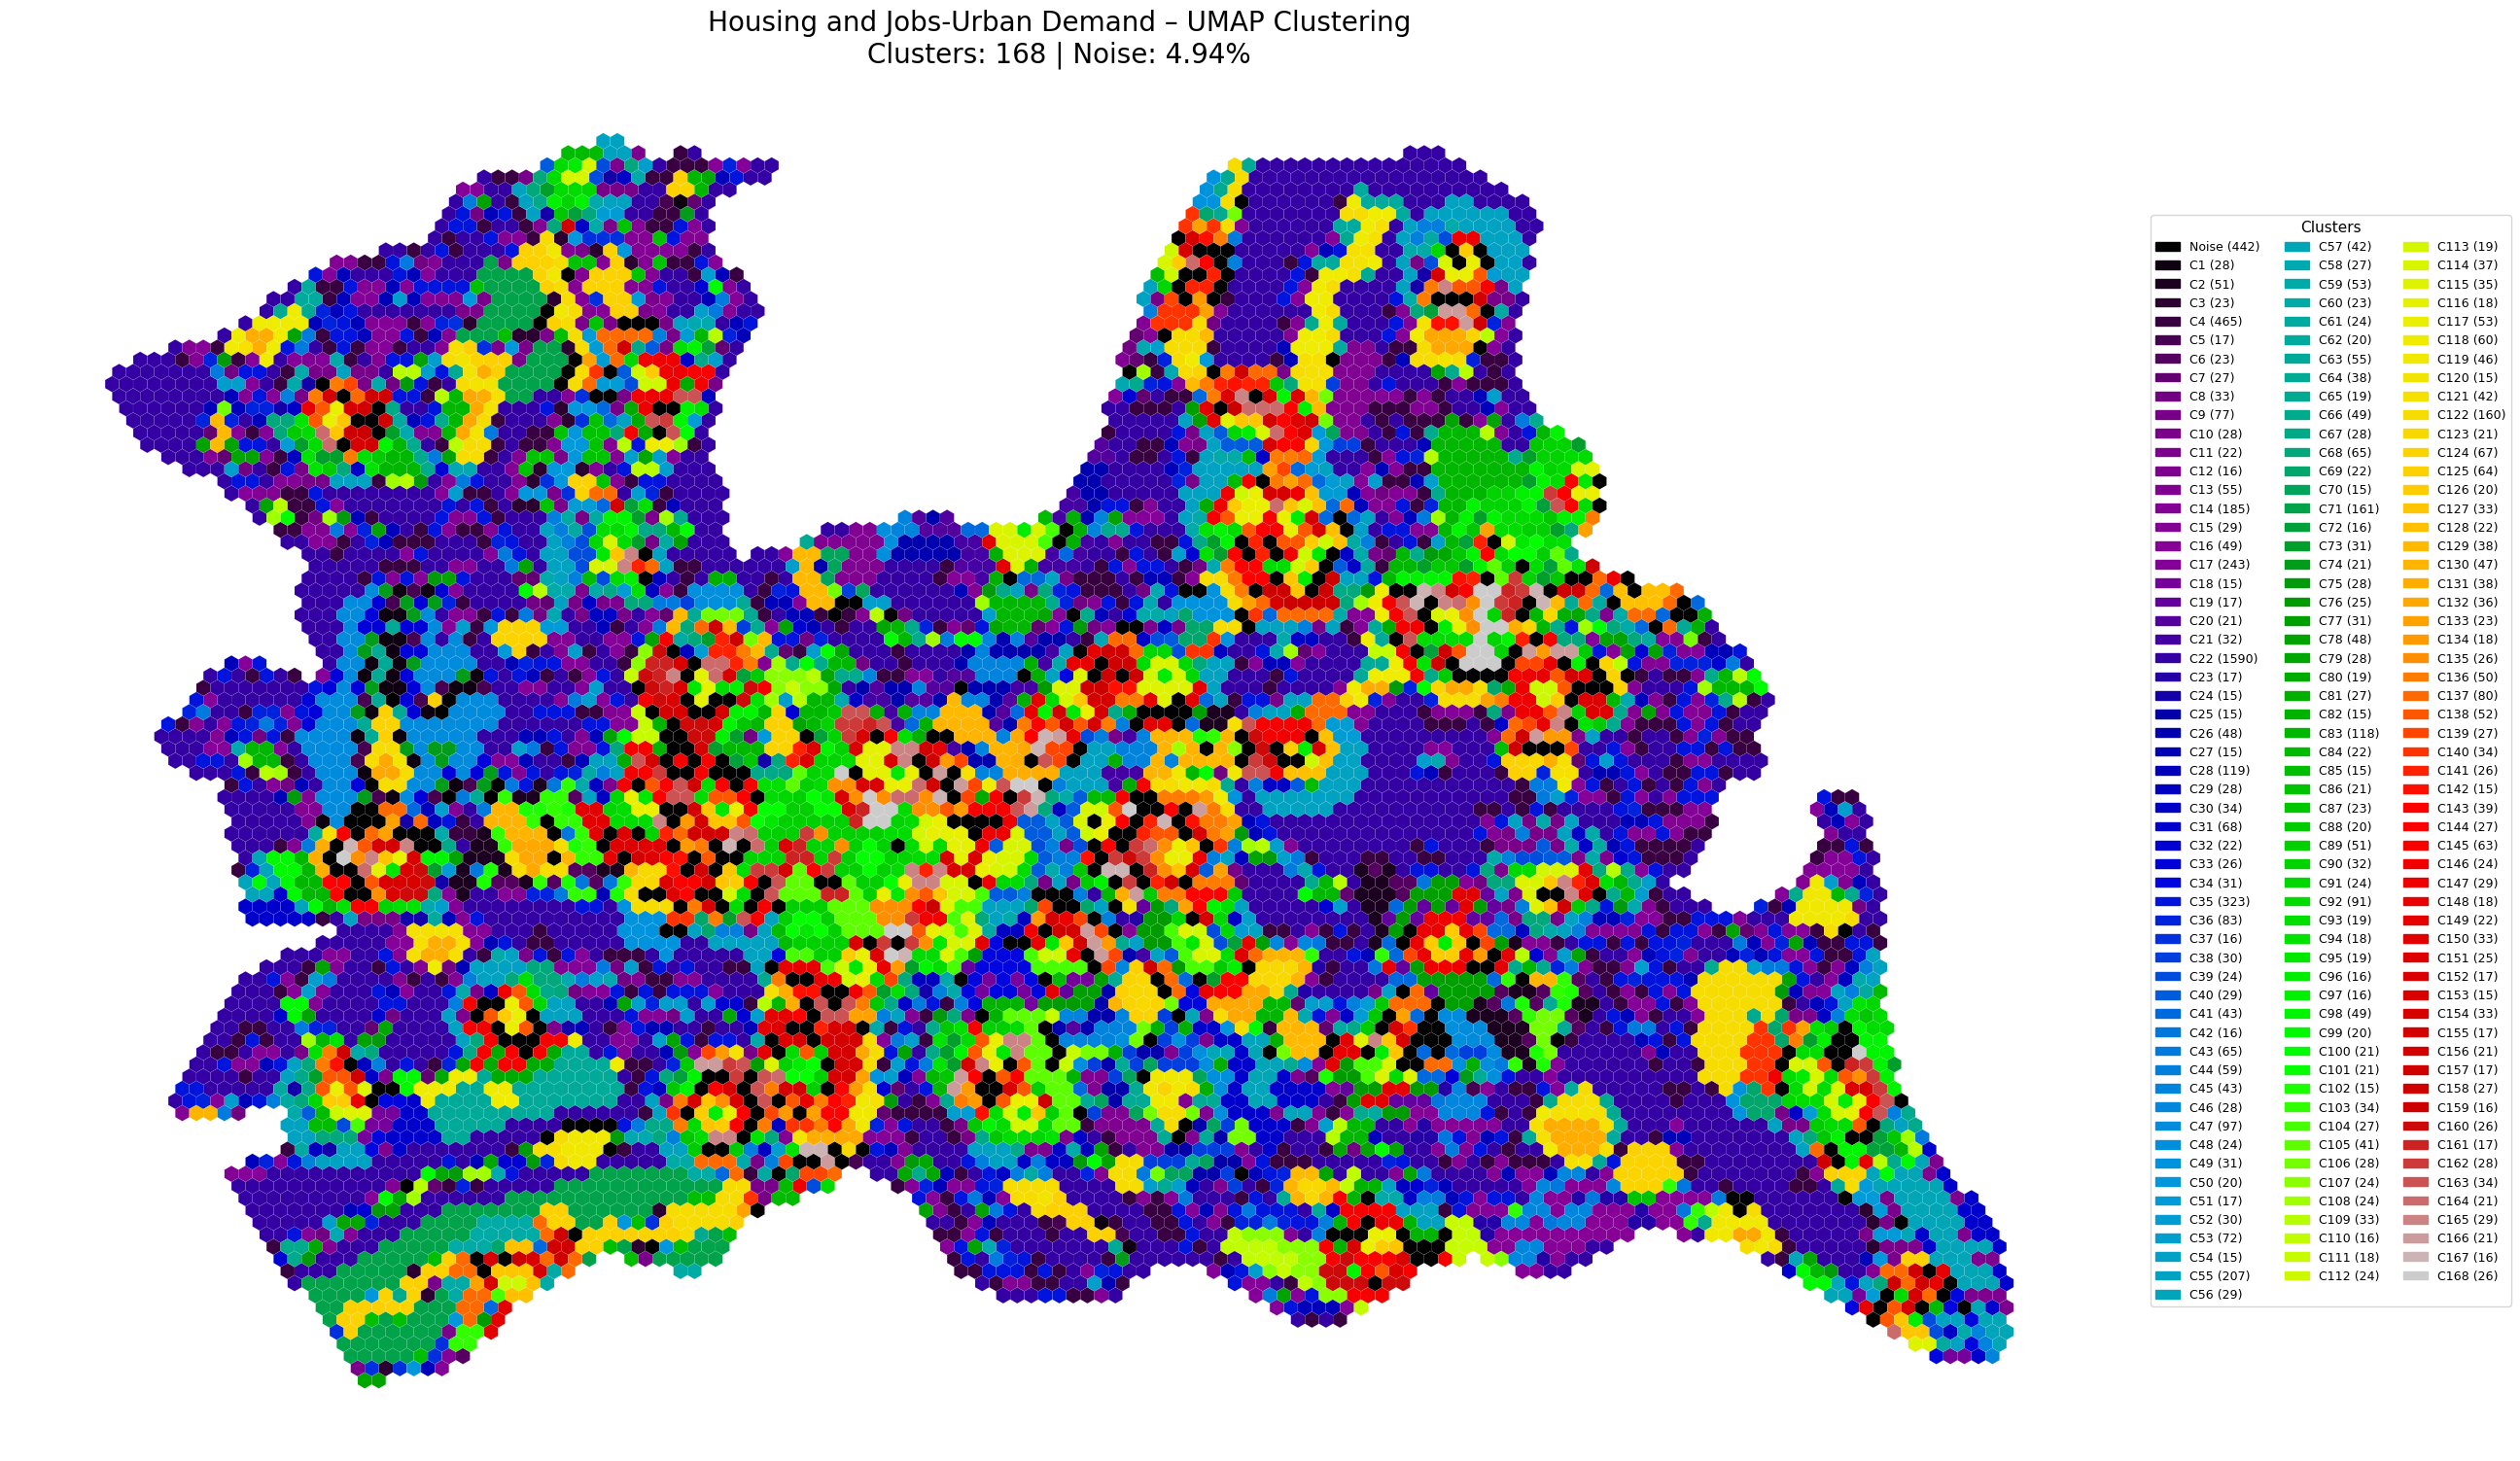

job_weighted_log  planned_housing_units_log  hub_overall_score  \
umap_cluster                                                                   
 21                   0.000000                   0.000000           2.000000   
 3                    0.693147                   0.000000           2.000000   
-1                    3.369854                   4.043482           3.113122   

              hex_count  
umap_cluster             
 21                1590  
 3                  465  
-1                  442

Running UMAP + HDBSCAN for: First and Last Mile Need Zones


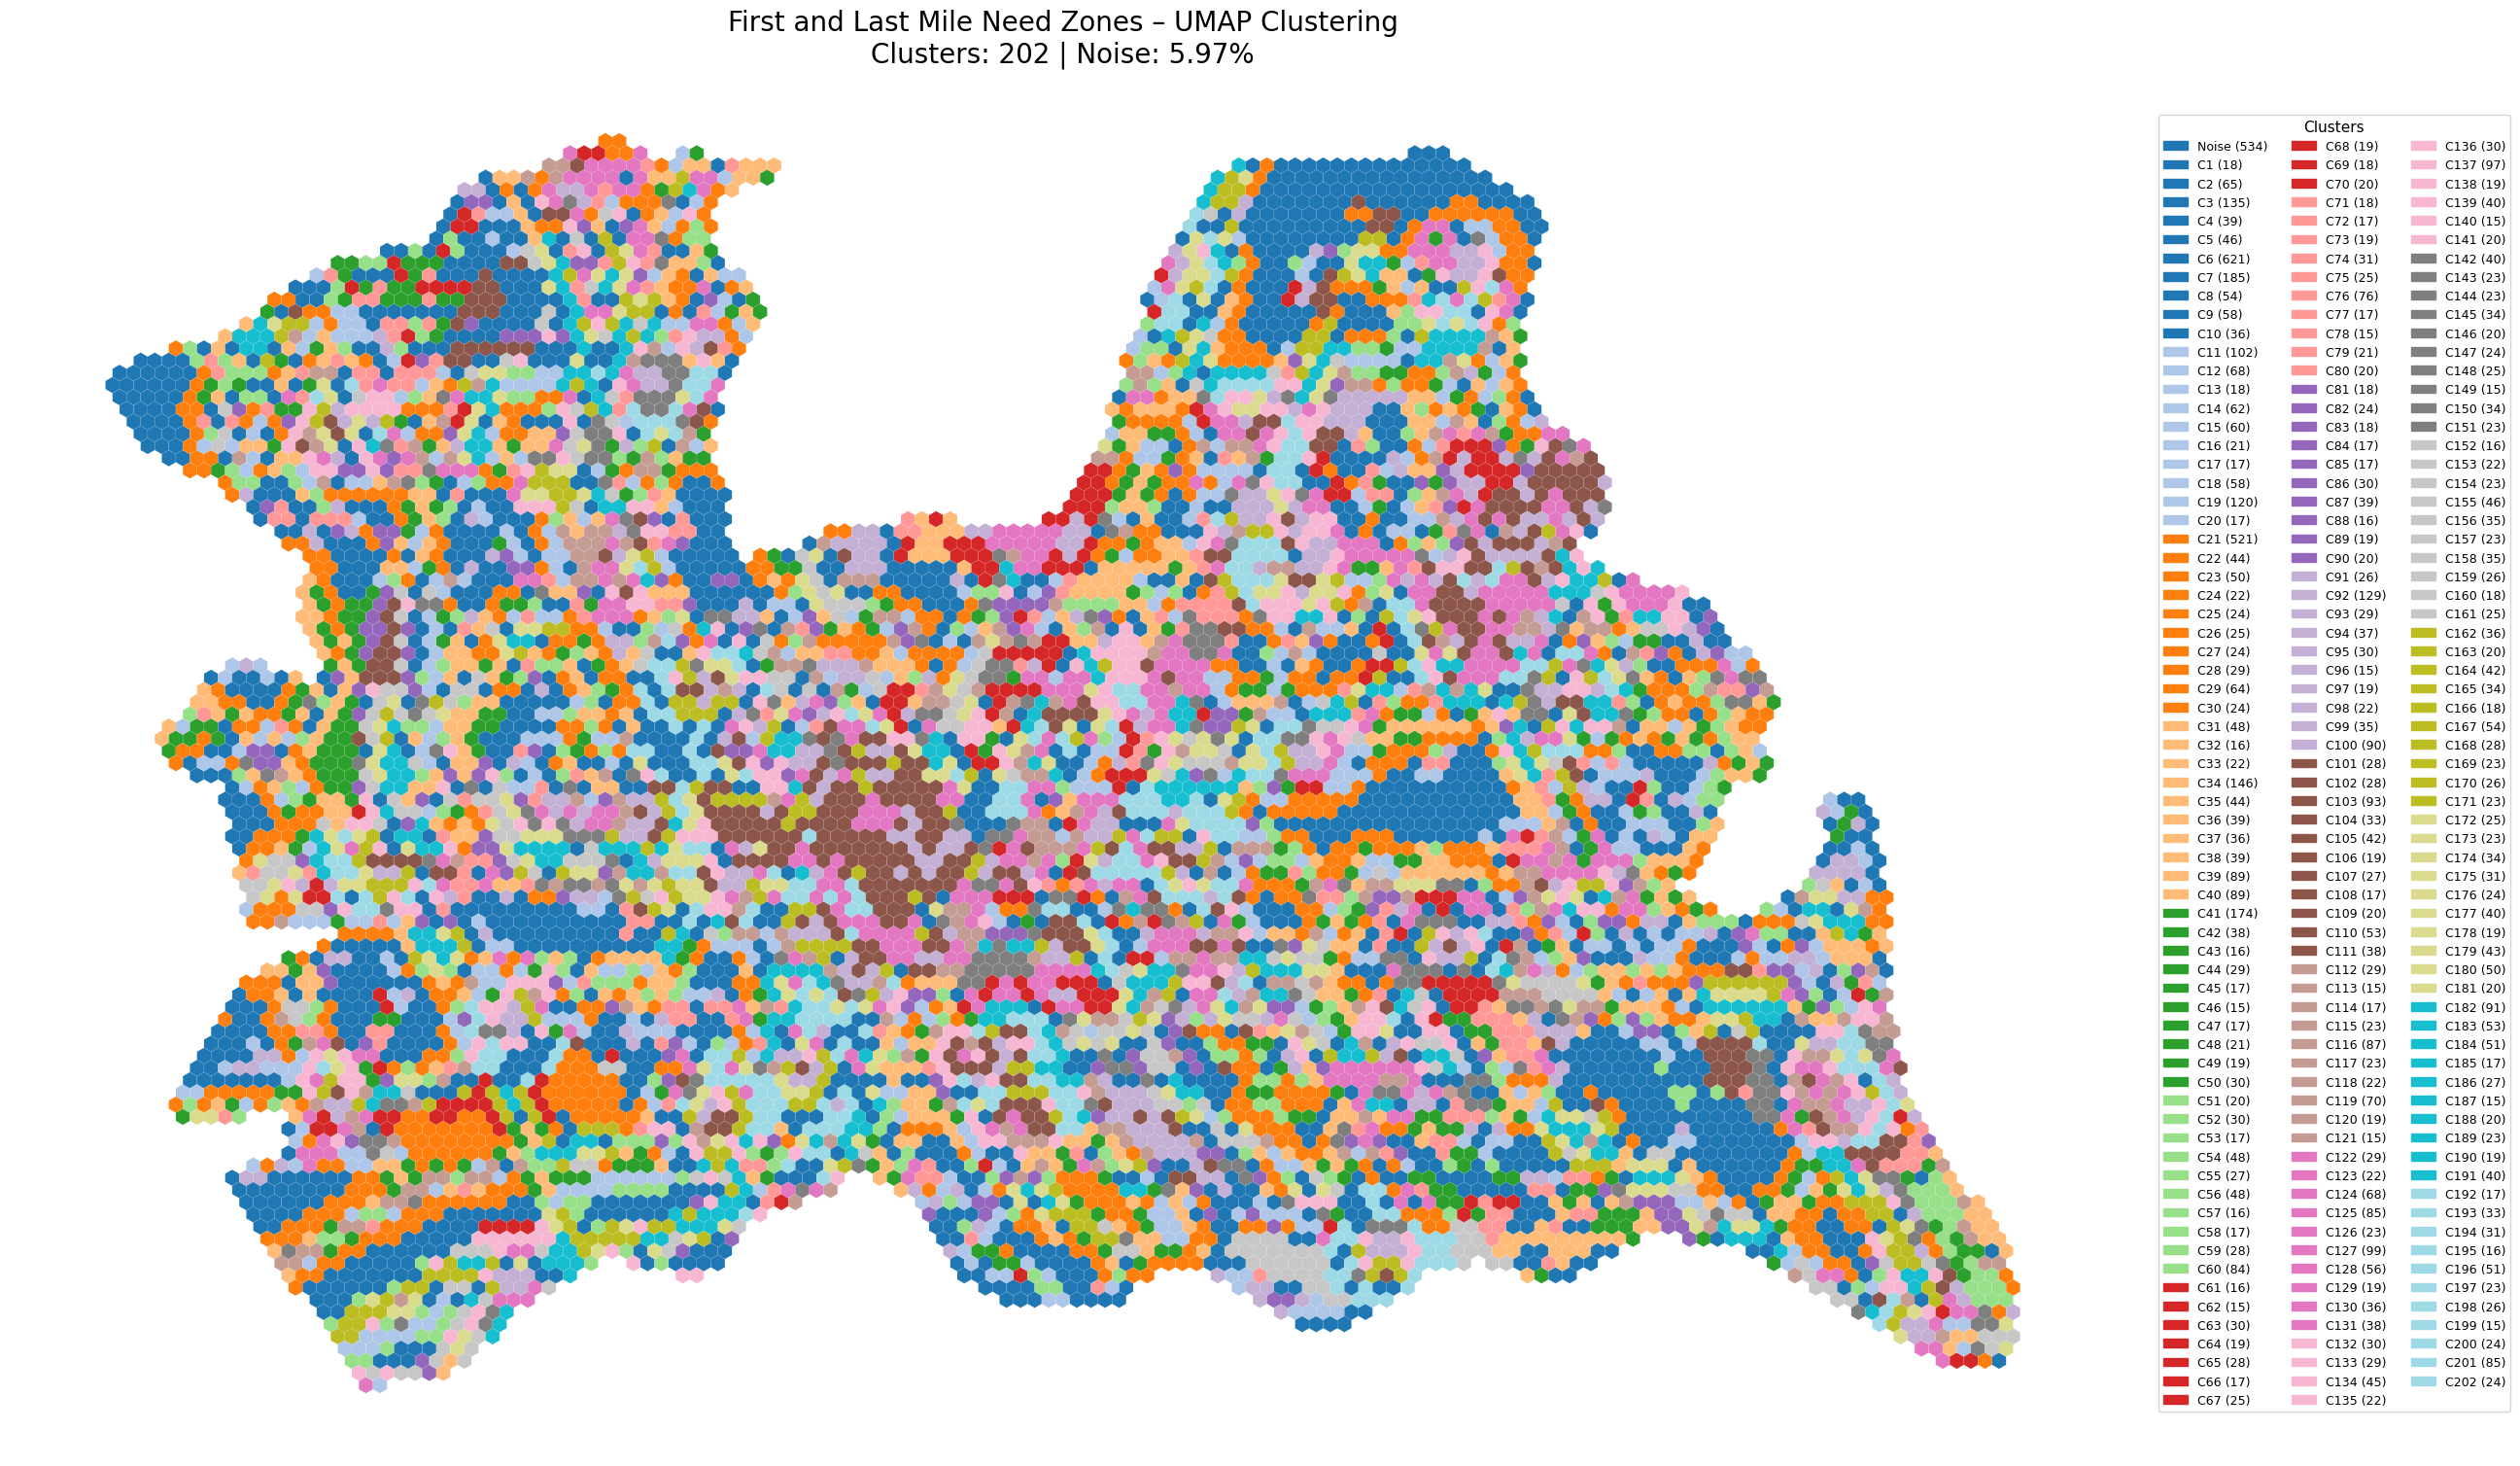

planned_housing_units_log  job_weighted_log  pt_access_score  \
umap_cluster                                                                 
 5                               0.0000          0.000000         1.000000   
-1                               3.6386          1.982697         2.801498   
 20                              0.0000          0.000000         2.000000   

              hub_distance_score  log_vehicle_availability  hex_count  
umap_cluster                                                           
 5                      1.000000                   0.00000        621  
-1                      1.606742                   0.00649        534  
 20                     1.000000                   0.00000        521

Running UMAP + HDBSCAN for: Infrastructure Availability


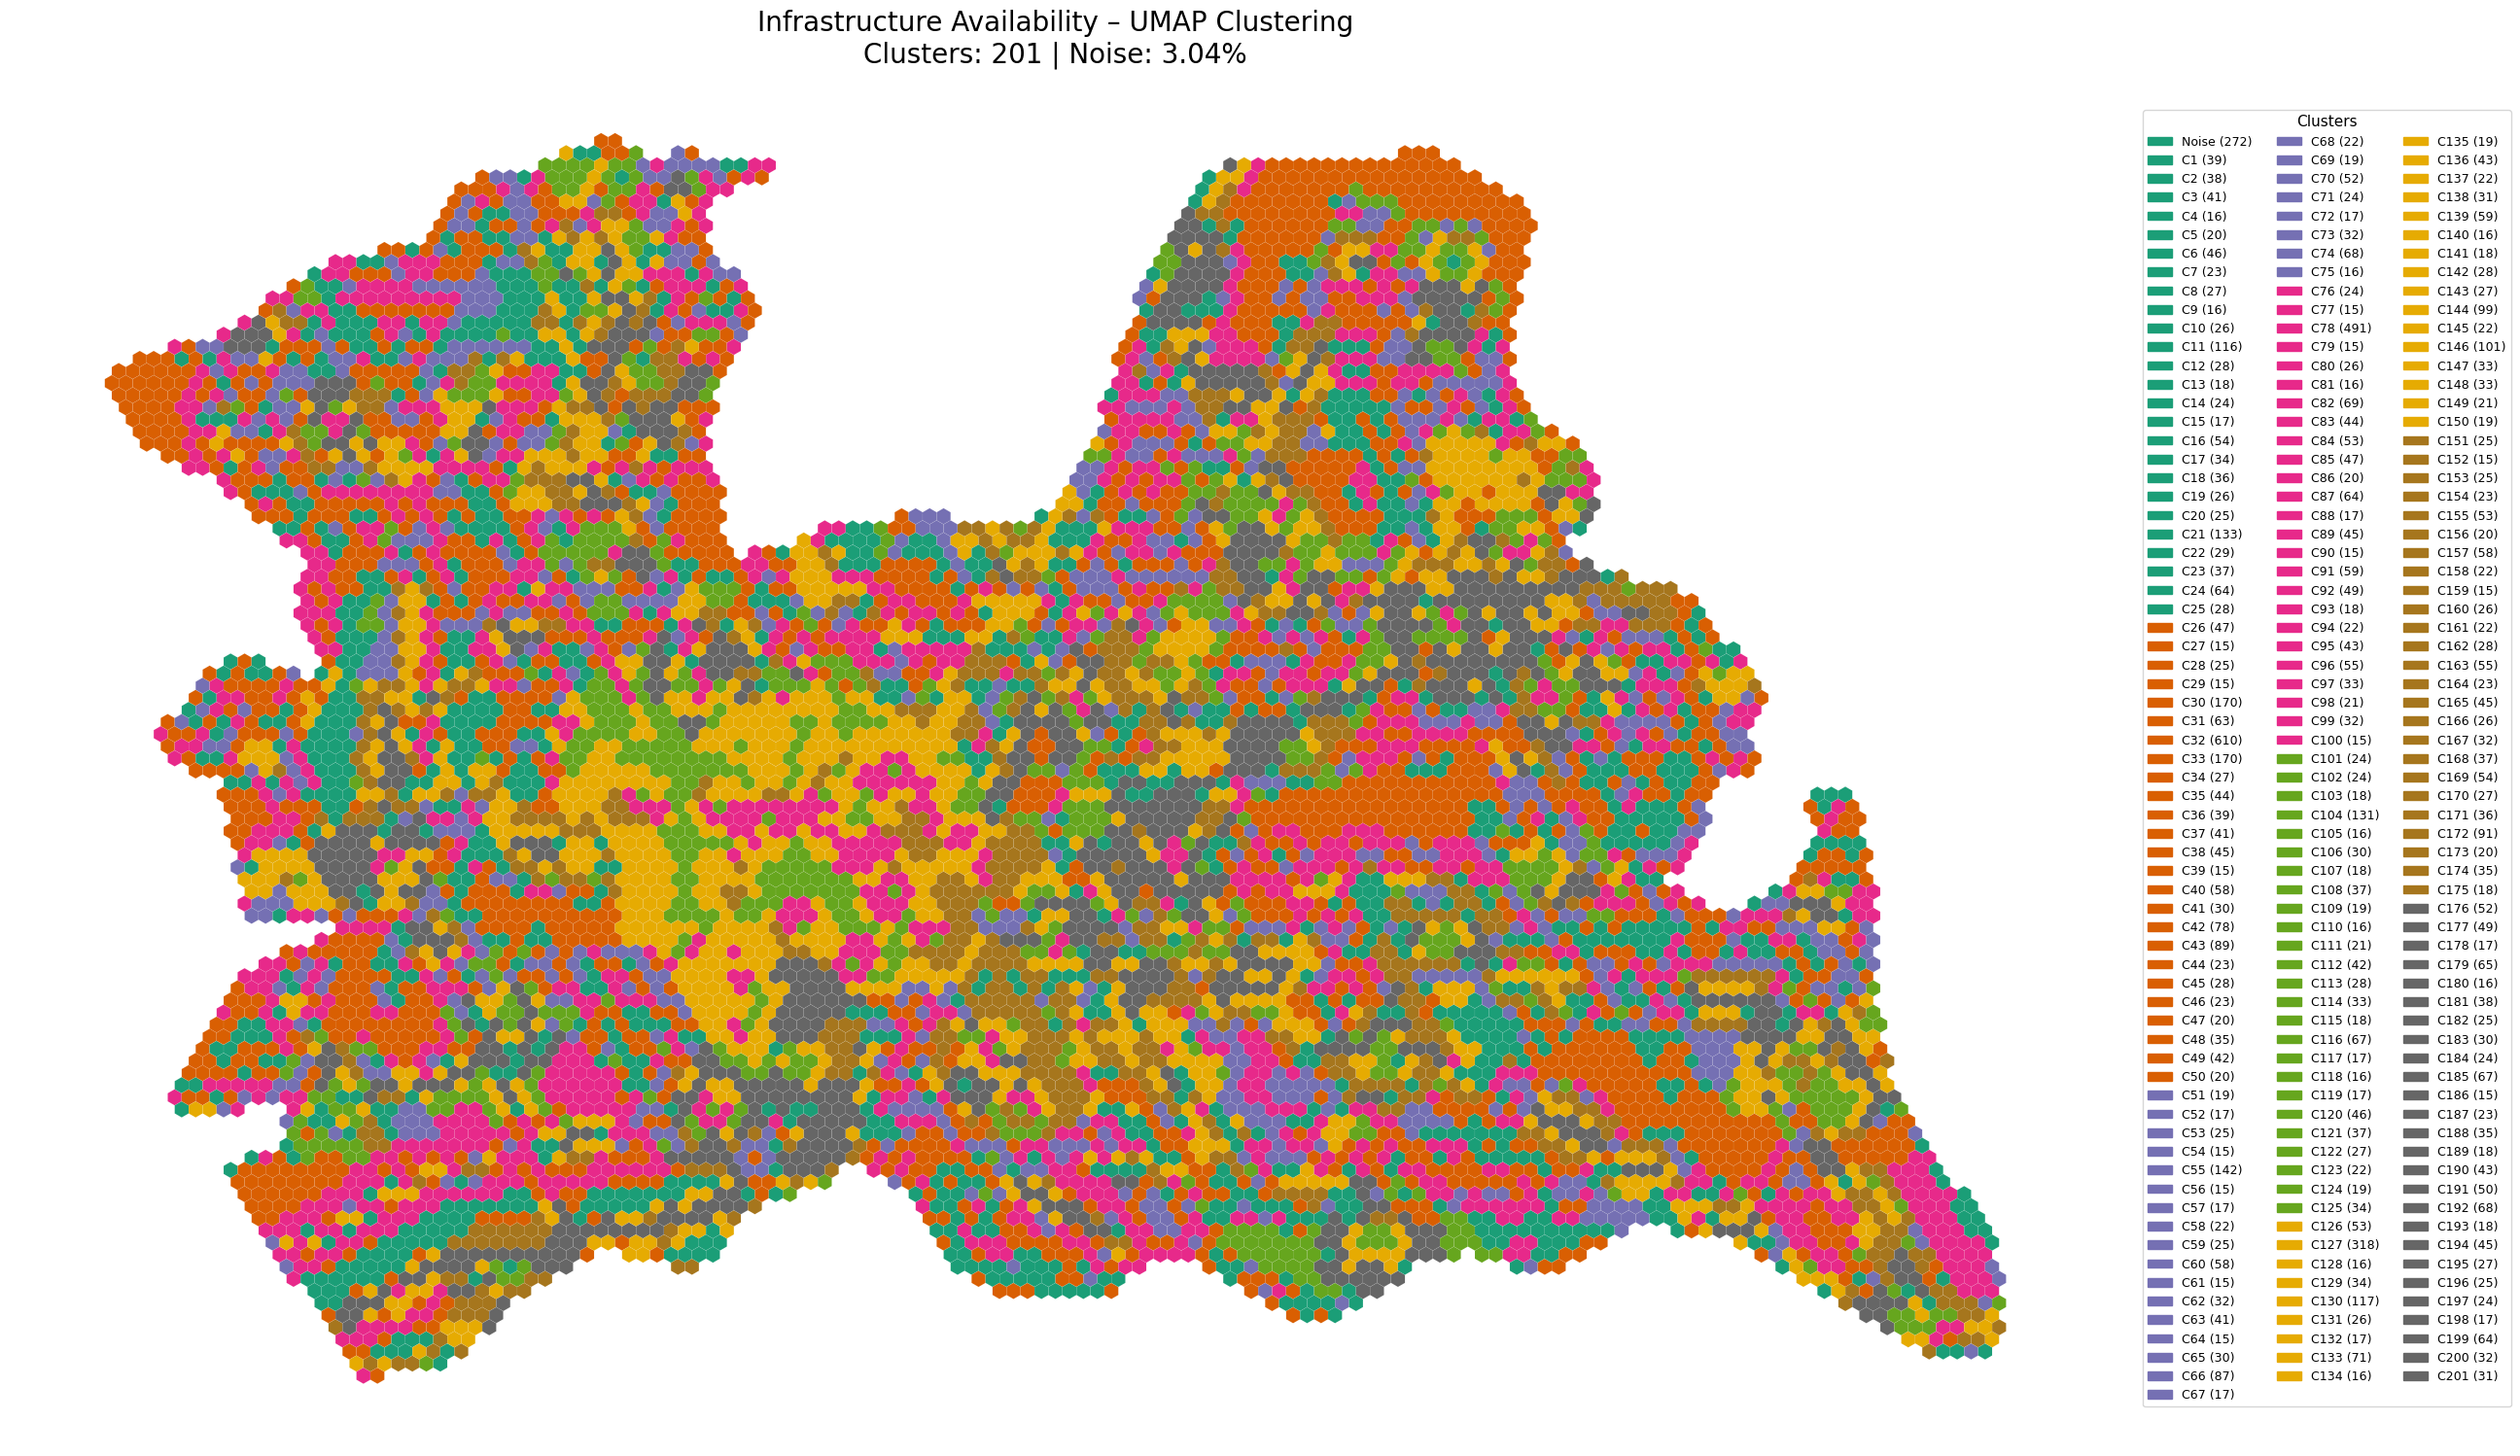

pt_access_score  hub_overall_score  has_ovfiets_access  \
umap_cluster                                                           
31                   1.000000                2.0                 0.0   
77                   2.000000                2.0                 0.0   
126                  3.003145                2.0                 0.0   

              planned_housing_units_log  housing_density_utrecht_2025_flag  \
umap_cluster                                                                 
31                             0.000000                                0.0   
77                             0.000000                                0.0   
126                            3.048001                                0.0   

              job_weighted_log  hex_count  
umap_cluster                               
31                    0.000000        610  
77                    0.000000        491  
126                   2.238886        318

In [13]:
summaries = {}

for set_name, features in feature_sets.items():
    print(f"Running UMAP + HDBSCAN for: {set_name}")
    
    # Step 1: Scale
    X_scaled = RobustScaler().fit_transform(utrecht_mobility[features].fillna(0))

    # Step 2: UMAP
    X_umap = umap.UMAP(random_state=42, init="random").fit_transform(X_scaled)

    # Step 3: HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
    labels = clusterer.fit_predict(X_umap)

    # Step 4: Plot
    utrecht_mobility = cluster_and_plot_from_umap_multicol_legend(
        gdf=utrecht_mobility,
        umap_embedding=X_umap,
        labels=labels,
        set_name=set_name,
        legend_columns=3
    )

    # Step 5: Save summary
    summary = generate_umap_cluster_summary(
        gdf=utrecht_mobility,
        features=features,
        cluster_column="umap_cluster"
    )
    
    # Assign the summary to a variable named after the set
    globals()[f"{set_name.replace(' ', '_').replace('-', '_')}"] = summary.copy()
    summaries[set_name] = summary.copy()
    display(summary.head(3))


--------------------------------------------------------------------------------------

## 5. SET 1: Housing and Jobs-Urban Demand - Identifying Gaps in Mobility Hub Coverage


Create a table that highlight clusters with **high housing and job demand** but **low access to mobility hubs**, based on the "Housing and Jobs – Urban Demand" feature set.

We compute a **gap score** using normalized demand metrics (`job_weighted_log` and `planned_housing_units_log`) divided by the access score (`hub_overall_score`). This prioritizes zones where investment in mobility infrastructure could have the **highest potential impact**.

These are potential target areas for **new mobility hubs**, **service improvements**, or deeper policy attention.


In [14]:
# Fix: Explicitly set cluster_column to the correct column name
cluster_column = "umap_cluster"
unique_labels = np.unique(utrecht_mobility[cluster_column])
cluster_map = {
    lab: f"C{i+1}" if lab != -1 else f"Noise ({(utrecht_mobility[cluster_column]==-1).sum()})"
    for i, lab in enumerate([l for l in unique_labels if l != -1])
}
utrecht_mobility["cluster_name"] = utrecht_mobility[cluster_column].map(cluster_map)


In [15]:
import numpy as np
import pandas as pd
from IPython.display import display

# Select the summary for the Housing and Jobs-Urban Demand set
set_name = "Housing and Jobs-Urban Demand"
summary_df = summaries[set_name].copy()  # <-- Fix: use summary_df throughout
print(f"Identifying gaps for: {set_name}")

# Define key variables
demand_cols = ["job_weighted_log", "planned_housing_units_log"]
supply_col = "hub_overall_score"

# Convert logs to raw scale (for display purposes only)
summary_df["job_weighted_raw"] = np.exp(summary_df["job_weighted_log"])
summary_df["planned_housing_raw"] = np.exp(summary_df["planned_housing_units_log"])

# Calculate demand score (weights can be adjusted later)
summary_df["demand_score"] = summary_df[demand_cols].sum(axis=1)

# Subtract supply to get gap score (high = high need for hubs)
summary_df["gap_score"] = summary_df["demand_score"] - summary_df[supply_col]

# Sort and show top clusters with biggest gaps
top_gaps = summary_df.sort_values("gap_score", ascending=False).head(20)
top_cluster_labels = top_gaps.index.tolist()

display(top_gaps[[
    "job_weighted_log",
    "planned_housing_units_log",
    "hub_overall_score",
    "hex_count",
    "gap_score",
    "job_weighted_raw",
    "planned_housing_raw"
]])


Identifying gaps for: Housing and Jobs-Urban Demand


job_weighted_log  planned_housing_units_log  hub_overall_score  \
umap_cluster                                                                   
104                   4.210023                   8.258610                3.0   
88                    4.929779                   8.198444                4.0   
160                   5.516872                   6.600684                3.0   
154                   4.606127                   7.258084                3.0   
100                   5.150281                   8.117803                5.0   
151                   5.569942                   6.669774                4.0   
161                   5.305737                   5.855435                3.0   
159                   4.539252                   6.425785                3.0   
167                   5.742665                   5.161946                3.0   
130                   4.612795                   4.818744                2.0   
134                   5.866417                   5.490418                4.0   
152                   4.733699                   6.564221                4.0   
106                   2.655083                   6.388965                2.0   
166                   5.133506                   4.902727                3.0   
115                   5.277178                   6.528819                5.0   
143                   4.872234                   5.873740                4.0   
162                   4.009716                   5.731400                3.0   
131                   4.533341                   4.180689                2.0   
119                   3.894940                   4.465806                2.0   
165                   4.443758                   4.717737                3.0   

              hex_count  gap_score  job_weighted_raw  planned_housing_raw  
umap_cluster                                                               
104                  41   9.468633         67.358101          3860.722160  
88                   51   9.128223        138.348985          3635.288797  
160                  17   9.117557        248.855416           735.598515  
154                  17   8.864211        100.095711          1419.534427  
100                  21   8.268084        172.479908          3353.645516  
151                  17   8.239715        262.418814           788.217166  
161                  28   8.161172        201.489362           349.126897  
159                  26   7.965036         93.620704           617.565279  
167                  26   7.904611        311.894539           174.503733  
130                  38   7.431539        100.765362           123.809500  
134                  26   7.356835        352.981914           242.358484  
152                  15   7.297919        113.715365           709.258883  
106                  24   7.044048         14.226162           595.240426  
166                  16   7.036233        169.610700           134.656492  
115                  18   6.805997        195.816563           684.589116  
143                  27   6.745974        130.612382           355.576239  
162                  34   6.741116         55.131228           308.400650  
131                  36   6.714030         93.069001            65.410896  
119                  15   6.360746         49.153125            86.991089  
165                  21   6.161494         85.094112           111.914653

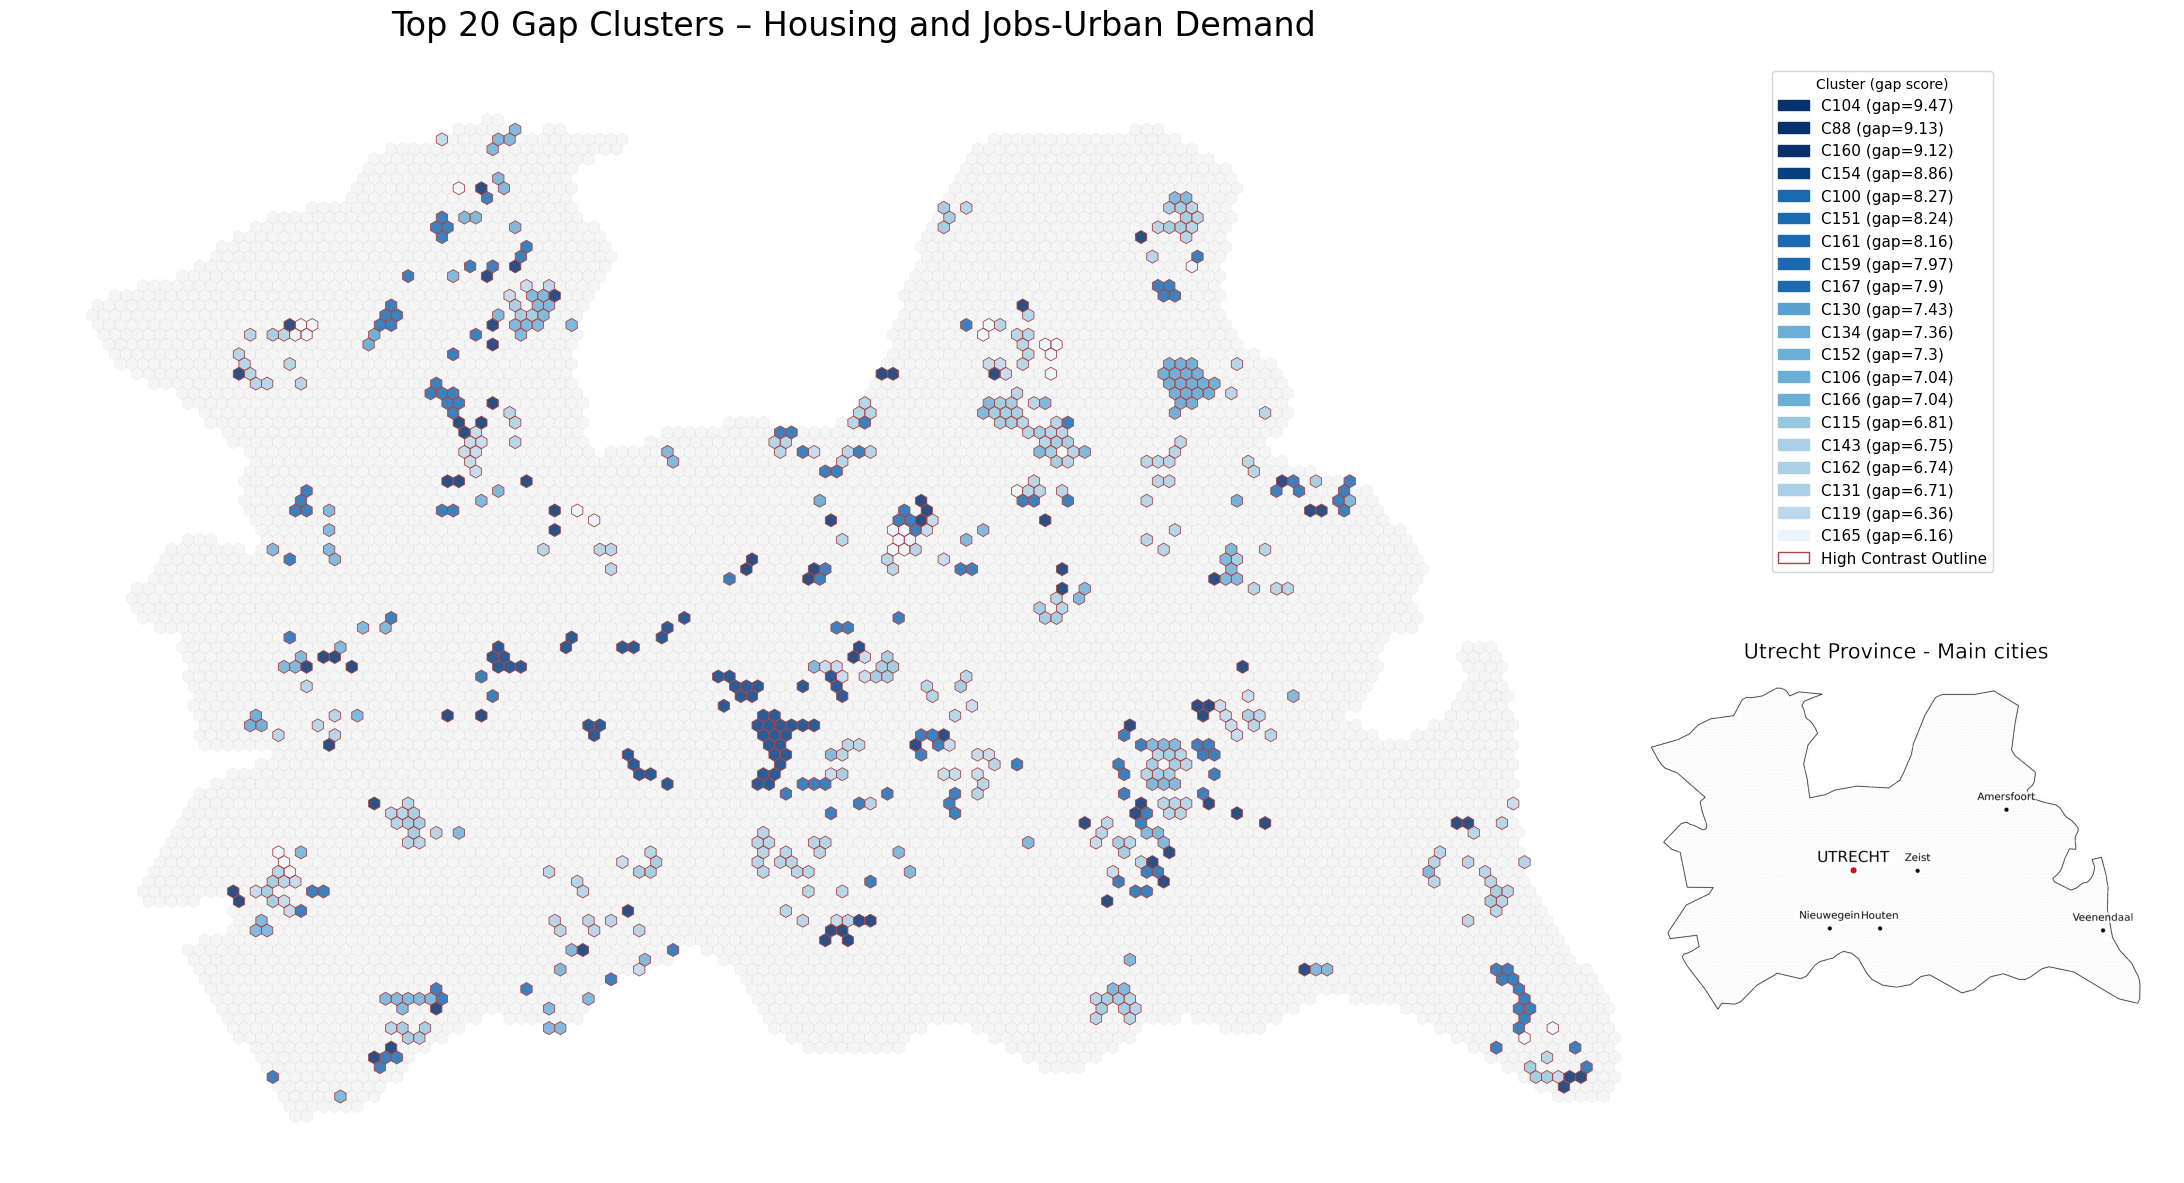

cluster_cname  umap_cluster  job_weighted_log  planned_housing_units_log  \
0           C104           104          4.210023                   8.258610   
1            C88            88          4.929779                   8.198444   
2           C160           160          5.516872                   6.600684   
3           C154           154          4.606127                   7.258084   
4           C100           100          5.150281                   8.117803   
5           C151           151          5.569942                   6.669774   
6           C161           161          5.305737                   5.855435   
7           C159           159          4.539252                   6.425785   
8           C167           167          5.742665                   5.161946   
9           C130           130          4.612795                   4.818744   
10          C134           134          5.866417                   5.490418   
11          C152           152          4.733699                   6.564221   
12          C106           106          2.655083                   6.388965   
13          C166           166          5.133506                   4.902727   
14          C115           115          5.277178                   6.528819   
15          C143           143          4.872234                   5.873740   
16          C162           162          4.009716                   5.731400   
17          C131           131          4.533341                   4.180689   
18          C119           119          3.894940                   4.465806   
19          C165           165          4.443758                   4.717737   

    hub_overall_score  hex_count  gap_score  job_weighted_raw  \
0                 3.0         41   9.468633         67.358101   
1                 4.0         51   9.128223        138.348985   
2                 3.0         17   9.117557        248.855416   
3                 3.0         17   8.864211        100.095711   
4                 5.0         21   8.268084        172.479908   
5                 4.0         17   8.239715        262.418814   
6                 3.0         28   8.161172        201.489362   
7                 3.0         26   7.965036         93.620704   
8                 3.0         26   7.904611        311.894539   
9                 2.0         38   7.431539        100.765362   
10                4.0         26   7.356835        352.981914   
11                4.0         15   7.297919        113.715365   
12                2.0         24   7.044048         14.226162   
13                3.0         16   7.036233        169.610700   
14                5.0         18   6.805997        195.816563   
15                4.0         27   6.745974        130.612382   
16                3.0         34   6.741116         55.131228   
17                2.0         36   6.714030         93.069001   
18                2.0         15   6.360746         49.153125   
19                3.0         21   6.161494         85.094112   

    planned_housing_raw  
0           3860.722160  
1           3635.288797  
2            735.598515  
3           1419.534427  
4           3353.645516  
5            788.217166  
6            349.126897  
7            617.565279  
8            174.503733  
9            123.809500  
10           242.358484  
11           709.258883  
12           595.240426  
13           134.656492  
14           684.589116  
15           355.576239  
16           308.400650  
17            65.410896  
18            86.991089  
19           111.914653


✔ Summary CSV exported
✔ GeoPackage exported


In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from pathlib import Path
import pandas as pd
import numpy as np

# --- CONFIG PATHS ---
try:
    from config import PROCESSED_DIR, QGIS_DIR, PROJECT_ROOT, OUTPUT_DIR
except ImportError:
    # Fallback: use notebook location (no __file__ in Jupyter)
    notebook_dir = Path().resolve()
    PROJECT_ROOT = notebook_dir.parent
    PROCESSED_DIR = PROJECT_ROOT / "1.0_data" / "1.2 - processed"
    QGIS_DIR = PROJECT_ROOT / "QGIS"
    OUTPUT_DIR = PROJECT_ROOT / "2.0_notebooks" / "0.0_outputs"
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    QGIS_DIR.mkdir(parents=True, exist_ok=True)
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- VARIABLES ---
set_name = "Housing and Jobs-Urban Demand"
cluster_column = "umap_cluster"

top_cluster_labels = top_gaps.index.tolist()

# --- FLAG AND FILTER ---
utrecht_mobility["top_gap_set_1"] = utrecht_mobility[cluster_column].isin(top_cluster_labels)
top_gap_gdf = utrecht_mobility[utrecht_mobility["top_gap_set_1"]].copy()

# --- CLEAN SUMMARY TABLE ---
top_gaps_clean = top_gaps.reset_index()
top_gaps_clean["cluster_cname"] = top_gaps_clean["umap_cluster"].apply(lambda x: f"C{x}")
columns_order = [
    "cluster_cname", "umap_cluster", "job_weighted_log", "planned_housing_units_log",
    "hub_overall_score", "hex_count", "gap_score", "job_weighted_raw", "planned_housing_raw"
]
top_gaps_clean = top_gaps_clean[columns_order]

# --- CREATE SUBFOLDERS ---
processed_clustering_dir = PROCESSED_DIR / "clustering_results"
processed_clustering_dir.mkdir(parents=True, exist_ok=True)
qgis_clustering_dir = QGIS_DIR / "clustering_results"
qgis_clustering_dir.mkdir(parents=True, exist_ok=True)

# --- EXPORT CLEAN SUMMARY AS CSV ---
csv_summary_path = processed_clustering_dir / "top_gap_summary_housing_jobs_urban_demand.csv"
top_gaps_clean.to_csv(csv_summary_path, index=False)

# --- MINIMAL GPKG EXPORT: GEOMETRIES + cluster ID ---
minimal_gdf = top_gap_gdf[[cluster_column, "geometry"]].copy()
gpkg_path = qgis_clustering_dir / "top_gap_clusters_housing_jobs_urban_demand.gpkg"
minimal_gdf.to_file(gpkg_path, driver="GPKG")

# --- PLOT MAP (Styled as requested, but keep blue shades for highlights) ---

# Prepare background and highlight layers
background_color_0 = "#f1f1f1"
background_color_not0 = "#f9f9f9"
edge_color = "#d0d0d0"
highlight_outline = "#aa4444"
highlight_alpha = 0.85
highlight_linewidth = 0.6

# All hexes not in top_gap
hexes_score_0 = utrecht_mobility[~utrecht_mobility["top_gap_set_1"]]
hexes_score_not0 = utrecht_mobility[utrecht_mobility["top_gap_set_1"] == False]
highlight_hexes = top_gap_gdf.copy()

# For blue shades: use gap_score, discretize for legend
gap_scores = top_gaps.loc[top_cluster_labels, "gap_score"].values
all_unique_scores = np.unique(np.round(gap_scores, 2))
# If all_unique_scores is not strictly increasing, sort and ensure unique
all_unique_scores = np.unique(all_unique_scores)

from matplotlib.colors import Normalize, BoundaryNorm

# Use Blues colormap, but discretized for unique scores
cmap_blues = plt.get_cmap("Blues", len(all_unique_scores))
norm = mcolors.BoundaryNorm(
    boundaries=[x - 0.5 for x in all_unique_scores] + [all_unique_scores[-1] + 0.5],
    ncolors=len(all_unique_scores)
)

# Use the global single figure size from plotting_globals.py if available
try:
    from plotting_globals import FIGSIZE_SINGLE
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE_SINGLE)
except ImportError:
    fig, ax = plt.subplots(1, 1, figsize=(22, 16))

# Plot all areas in light grey for the "empty" (non-top-gap) ones
hexes_score_0.plot(ax=ax, color=background_color_0, edgecolor=edge_color, linewidth=0.2, zorder=1, alpha=0.7)
# (hexes_score_not0 is the same as hexes_score_0, but included for style parity)
# hexes_score_not0.plot(ax=ax, color=background_color_not0, edgecolor=edge_color, linewidth=0.2, zorder=1, alpha=0.7)

# Plot highlighted clusters with blue shades
highlight_hexes = highlight_hexes.copy()
# Map gap_score to nearest unique value for discrete coloring
highlight_hexes["gap_score_discrete"] = highlight_hexes[cluster_column].map(
    dict(zip(top_cluster_labels, np.round(gap_scores, 2)))
)
highlight_hexes.plot(
    ax=ax,
    column="gap_score_discrete",
    cmap=cmap_blues,
    norm=norm,
    edgecolor="none",
    alpha=highlight_alpha,
    zorder=2
)
highlight_hexes.boundary.plot(
    ax=ax,
    color=highlight_outline,
    linewidth=highlight_linewidth,
    zorder=3
)

ax.set_title("Top 20 Gap Clusters – Housing and Jobs-Urban Demand", fontsize=24, pad=20)
ax.axis("off")

# Build legend: one patch per cluster, with color
from matplotlib.colors import to_hex
legend_patches = []
for i, cl in enumerate(top_cluster_labels):
    score = np.round(gap_scores[i], 2)
    color = to_hex(cmap_blues(norm(score)))
    cname = f"C{cl}"
    legend_patches.append(mpatches.Patch(color=color, label=f"{cname} (gap={score})"))

# Add high-contrast outline legend
contrast_patch = mpatches.Patch(facecolor="none", edgecolor=highlight_outline, linewidth=1, label="High Contrast Outline")
# Place legend outside right, at the top
legend = ax.legend(
    handles=legend_patches + [contrast_patch],
    loc="upper right",
    fontsize=11,
    title="Cluster (gap score)",
    bbox_to_anchor=(1.18, 1)
)

# --- ADD PICTOGRAM OUTSIDE HEXES, UNDER THE LEGEND ---
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Use the pictogram at OUTPUT_DIR/pictogram.png
pictogram_path = OUTPUT_DIR / "pictogram.png"
if pictogram_path.exists():
    img = mpimg.imread(str(pictogram_path))
    imagebox = OffsetImage(img, zoom=0.18, resample=True)
    # Place pictogram just below the legend, outside the axes
    # The legend is at (1.18, 1), so pictogram at (1.18, 0.13) (tweak as needed)
    ab = AnnotationBbox(
        imagebox,
        (1.28, 0.13),  # (x, y) in axes fraction, moved more to the right
        xycoords='axes fraction',
        frameon=False,
        box_alignment=(1, 0)
    )
    ax.add_artist(ab)
else:
    print(f"No pictogram file found at {pictogram_path.resolve()}")

plt.tight_layout()
plt.show()

# --- DISPLAY CLEAN SUMMARY ---
from IPython.display import display
display(top_gaps_clean)
print(f"\n✔ Summary CSV exported")
print(f"✔ GeoPackage exported")


## 6. SET 2: First and Last Mile Need Zones - Cluster Ranking

To prioritize areas where last-mile solutions are most urgently needed, we ranked UMAP clusters based on a composite gap score derived from five key features. Each feature represents either a form of access or need. Features where a lower value indicates greater need (e.g. distance to hub) were inverted before scoring. Final scores were computed as a weighted average of the normalized indicators.

This method does not yet account for the quality or type of mobility hubs (e.g. megastations vs. local hubs). It focuses strictly on access distance and service presence, not service level.

---

📊 **Method Summary: First and Last Mile Need Zones Gap Analysis**

We ranked clusters based on a weighted scoring system that reflects where **mobility infrastructure is lacking** despite high **demand** (housing + jobs). The criteria and their respective influence were:

🚩 **Selected Indicators and Weights**

| Feature                     | Weight | Rationale                             |
| --------------------------- | ------ | ------------------------------------- |
| `planned_housing_units_log` | 0.3    | High housing demand = higher need     |
| `job_weighted_log`          | 0.3    | High job density = higher need        |
| `pt_access_score`           | 0.15   | Lower PT access = more underserved    |
| `hub_distance_score`        | 0.15   | Longer distance = worse accessibility |
| `log_vehicle_availability`  | 0.10   | Fewer vehicles = less supply          |

🔁 **Preprocessing Steps**

* Inverted features where **low = bad** to align all scoring (e.g. PT access).
* Scaled all features to the **same range** using MinMaxScaler.
* Applied **weights** and calculated a final **gap score** per cluster.
* Flagged top 5 clusters as `"top_gap"`.




In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Import PROCESSED_DIR from config.py in 1.0_data/1.2 - processed ---
import sys
import pathlib

# Add the path to the config.py file in 1.0_data/1.2 - processed
config_path = pathlib.Path("../1.0_data/1.2 - processed")
sys.path.insert(0, str(config_path.resolve()))
from config import PROCESSED_DIR

# Step 1: Define weights (as before)
features_weights = {
    "planned_housing_units_log": 0.3,
    "job_weighted_log": 0.3,
    "pt_access_score": 0.3,           # will be inverted
    "hub_distance_score": 0.15,        # will be inverted
    "log_vehicle_availability": 0.15  # will be inverted
}

# Step 2: Group by cluster and take the mean (summary of cluster characteristics)
cluster_scores = utrecht_mobility.groupby("umap_cluster").mean(numeric_only=True)

# Step 3: Invert features where low values = worse access
invert_features = ["pt_access_score", "hub_distance_score", "log_vehicle_availability"]
for col in invert_features:
    cluster_scores[f"{col}_inv"] = cluster_scores[col].max() - cluster_scores[col]

# Step 4: Prepare DataFrame with features to scale
processed_features = {
    "planned_housing_units_log": cluster_scores["planned_housing_units_log"],
    "job_weighted_log": cluster_scores["job_weighted_log"],
    "pt_access_score_inv": cluster_scores["pt_access_score_inv"],
    "hub_distance_score_inv": cluster_scores["hub_distance_score_inv"],
    "log_vehicle_availability_inv": cluster_scores["log_vehicle_availability_inv"]
}
df_scaled_input = pd.DataFrame(processed_features)

# Step 5: Normalize (0–1)
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_scaled_input)
df_scaled = pd.DataFrame(scaled_array, index=df_scaled_input.index, columns=df_scaled_input.columns)

# Step 6: Apply Weights
# The order of weights must match the columns in df_scaled
weight_list = [
    features_weights["planned_housing_units_log"],
    features_weights["job_weighted_log"],
    features_weights["pt_access_score"],
    features_weights["hub_distance_score"],
    features_weights["log_vehicle_availability"]
]
for col, weight in zip(df_scaled.columns, weight_list):
    df_scaled[col] = df_scaled[col] * weight

# Step 7: Compute Final Gap Score
df_scaled["gap_score_set_2"] = df_scaled.sum(axis=1)

# Step 8: Save Results
cluster_gap_scores = cluster_scores.copy()
cluster_gap_scores["gap_score_set_2"] = df_scaled["gap_score_set_2"]

# Step 9: Flag Top 5 Clusters with Highest Gaps
cluster_gap_scores["is_top_gap_set_2"] = cluster_gap_scores["gap_score_set_2"].rank(ascending=False, method="dense") <= 5

# Optional: Save to disk
export_path = PROCESSED_DIR / "clustering_results"
export_path.mkdir(parents=True, exist_ok=True)
cluster_gap_scores.to_csv(export_path / "top_gap_summary_First_and_Last_Mile_Need_Zones.csv")

cluster_gap_scores.head()


log_vehicle_availability  has_ovfiets_access  \
umap_cluster                                                 
-1                            0.010193            0.003676   
 0                            0.000000            0.000000   
 1                            0.000000            0.000000   
 2                            0.000000            0.000000   
 3                            0.000000            0.000000   

              hub_distance_score  hub_overall_score  pt_line_distance  \
umap_cluster                                                            
-1                      1.647059           2.658088        524.579098   
 0                      1.000000           2.000000        747.741818   
 1                      1.000000           2.000000       1261.909994   
 2                      1.000000           2.000000       1475.792246   
 3                      1.000000           2.000000       1458.200123   

              pt_access_score  job_weighted_log  planned_housing_units_log  \
umap_cluster                                                                 
-1                   2.941176          1.865921                   2.953794   
 0                   2.000000          0.000000                   2.704381   
 1                   1.000000          0.000000                   2.708050   
 2                   1.000000          1.791759                   0.000000   
 3                   1.000000          1.791759                   0.000000   

              planned_density_score_log  absolute_growth_utrecht_2025_flag  \
umap_cluster                                                                 
-1                             1.593749                                0.0   
 0                             0.000000                                0.0   
 1                             0.000000                                0.0   
 2                             0.000000                                0.0   
 3                             0.000000                                0.0   

              housing_density_utrecht_2025_flag  color_code  top_gap_set_1  \
umap_cluster                                                                 
-1                                          0.0         0.0            0.0   
 0                                          0.0         1.0            0.0   
 1                                          0.0         2.0            0.0   
 2                                          0.0         3.0            0.0   
 3                                          0.0         4.0            0.0   

              pt_access_score_inv  hub_distance_score_inv  \
umap_cluster                                                
-1                       1.058824                2.352941   
 0                       2.000000                3.000000   
 1                       3.000000                3.000000   
 2                       3.000000                3.000000   
 3                       3.000000                3.000000   

              log_vehicle_availability_inv  gap_score_set_2  is_top_gap_set_2  
umap_cluster                                                                   
-1                                0.974833         0.553942             False  
 0                                0.985026         0.548856             False  
 1                                0.985026         0.623990             False  
 2                                0.985026         0.621470             False  
 3                                0.985026         0.621470             False

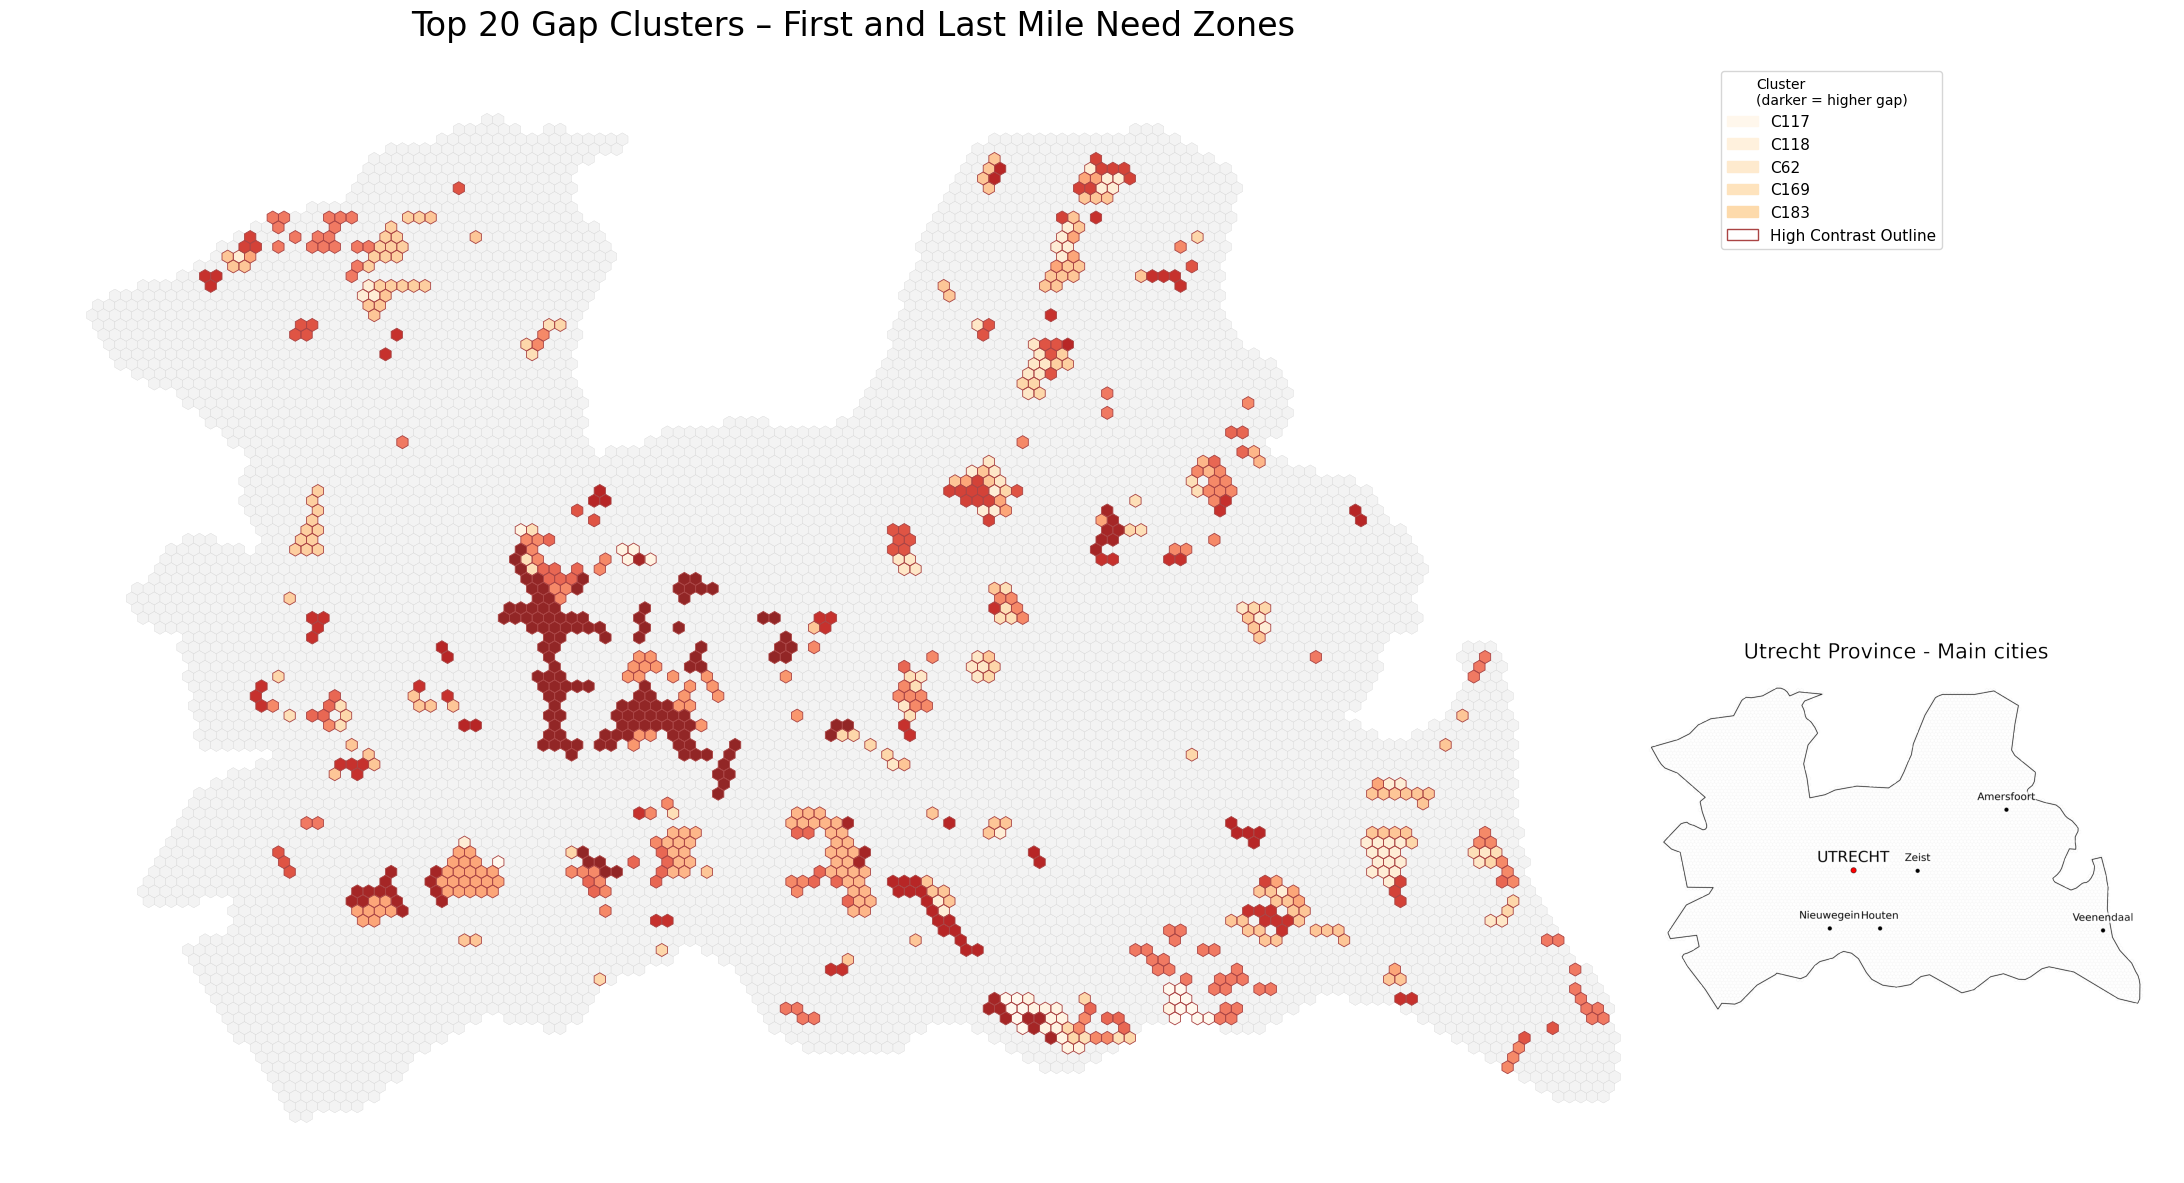

In [18]:
# Plot the top 20 gap clusters using the requested style, but keep the orange shades (OrRd colormap)
# Add the Utrecht pictogram image to the corner of the map

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from IPython.display import display

# --- Use OUTPUT_DIR from config.py for pictogram path ---
from config import OUTPUT_DIR

theme_name = "First and Last Mile Need Zones"
cluster_col = "umap_cluster"

# Get top 20 clusters by gap score
top_20_gap_clusters = cluster_gap_scores.sort_values("gap_score_set_2", ascending=False).head(20).index.tolist()

# Sort clusters by gap score descending (so darkest = highest gap)
top_gap_clusters_sorted = cluster_gap_scores.loc[top_20_gap_clusters].sort_values("gap_score_set_2", ascending=False).index.tolist()

# Filter hexes in those clusters
top_gap_hexes = utrecht_mobility[utrecht_mobility[cluster_col].isin(top_gap_clusters_sorted)].copy()

# Split all hexes into those in top clusters and those not, for background
hexes_score_not0 = utrecht_mobility[~utrecht_mobility[cluster_col].isin(top_gap_clusters_sorted)]
hexes_score_0 = utrecht_mobility[utrecht_mobility[cluster_col].isin(top_gap_clusters_sorted) == False]
highlight_hexes = top_gap_hexes.copy()

# For colormap normalization, assign a unique rank to each cluster (0 = highest gap, 19 = lowest in top 20)
all_unique_scores = list(range(len(top_gap_clusters_sorted)))  # 0..19

# Map cluster to rank (0 = highest gap)
cluster_to_rank = {cl: i for i, cl in enumerate(top_gap_clusters_sorted)}

# Add a column to highlight_hexes for plotting
highlight_hexes = highlight_hexes.copy()
highlight_hexes["gap_rank"] = highlight_hexes[cluster_col].map(cluster_to_rank)

# Colors and colormap
background_color_0 = "#f1f1f1"
background_color_not0 = "#f9f9f9"
edge_color = "#d0d0d0"
highlight_outline = "#aa4444"
highlight_alpha = 0.85
highlight_linewidth = 0.6

# Use OrRd colormap for orange shades
cmap_orange = plt.get_cmap("OrRd", len(all_unique_scores))
norm = mcolors.BoundaryNorm(
    boundaries=[x - 0.5 for x in all_unique_scores] + [all_unique_scores[-1] + 0.5],
    ncolors=len(all_unique_scores)
)

fig, ax = plt.subplots(1, 1, figsize=(22, 16))
# Plot all hexes not in top clusters as background
hexes_score_not0.plot(ax=ax, color=background_color_not0, edgecolor=edge_color, linewidth=0.2, zorder=1, alpha=0.7)
# Plot all hexes in top clusters as background (redundant, but for clarity)
hexes_score_0.plot(ax=ax, color=background_color_0, edgecolor=edge_color, linewidth=0.2, zorder=1, alpha=0.7)
# Plot highlighted clusters with orange shades
highlight_hexes.plot(
    ax=ax,
    column="gap_rank",
    cmap=cmap_orange,
    norm=norm,
    edgecolor="none",
    alpha=highlight_alpha,
    zorder=2
)
highlight_hexes.boundary.plot(
    ax=ax,
    color=highlight_outline,
    linewidth=highlight_linewidth,
    zorder=3
)
ax.set_title(f"Top 20 Gap Clusters – {theme_name}", fontsize=24, pad=20)
ax.axis("off")

# --- Add Utrecht pictogram image to the corner of the map ---
# Use the pictogram at OUTPUT_DIR/pictogram.png
pictogram_path = OUTPUT_DIR / "pictogram.png"
if pictogram_path.exists():
    img = mpimg.imread(str(pictogram_path))
    imagebox = OffsetImage(img, zoom=0.18, resample=True)
    # Place pictogram just below the legend, outside the axes
    # The legend is at (1.18, 1), so pictogram at (1.18, 0.13) (tweak as needed)
    ab = AnnotationBbox(
        imagebox,
        (1.28, 0.13),  # (x, y) in axes fraction, moved more to the right
        xycoords='axes fraction',
        frameon=False,
        box_alignment=(1, 0)
    )
    ax.add_artist(ab)
else:
    print(f"No pictogram file found at {pictogram_path.resolve()}")

# Build legend patches, sorted so that the first entry is the darkest (highest gap)
# We'll show only the top 5 for clarity, but you can adjust as needed
legend_patches = []
for i, cl in enumerate(top_gap_clusters_sorted):
    color = cmap_orange(norm(i))
    cname = f"C{cl}"
    if i < 5:  # Only show top 5 in legend for readability
        legend_patches.append(mpatches.Patch(color=color, label=cname))
# Add a patch for the outline
contrast_patch = mpatches.Patch(facecolor="none", edgecolor=highlight_outline, linewidth=1, label="High Contrast Outline")
ax.legend(handles=legend_patches + [contrast_patch], title="Cluster\n(darker = higher gap)", loc="upper right", bbox_to_anchor=(1.15, 1), fontsize=11)
plt.tight_layout()
plt.show()

# Display a summary table of the top 20 gap clusters with key indicators

summary_cols = [
    "umap_cluster",
    "gap_score_set_2",
    "job_weighted_log",
    "planned_housing_units_log",
    "hub_overall_score",
    "pt_access_score",
    "has_ovfiets_access"
]

# Prepare summary DataFrame and print the top 20, formatting cluster names as C1, C2, ...
top_gap_summary = (
    cluster_gap_scores.loc[top_gap_clusters_sorted]
    .reset_index()
    .loc[:, summary_cols]
    .rename(columns={
        "umap_cluster": "Cluster",
        "gap_score_set_2": "Gap Score",
        "job_weighted_log": "Job Score",
        "planned_housing_units_log": "Planned Housing",
        "hub_overall_score": "Hub Score",
        "pt_access_score": "PT Access",
        "has_ovfiets_access": "OV-fiets Access"
    })
)

# Format cluster numbers as C1, C2, ...
top_gap_summary["Cluster"] = top_gap_summary["Cluster"].apply(lambda x: f"C{int(x)+1}" if isinstance(x, (int, float)) and not pd.isnull(x) else f"C{x}")

# Pretty print as a table
display(top_gap_summary.head(20).style.format({
    "Gap Score": "{:.3f}",
    "Job Score": "{:.2f}",
    "Planned Housing": "{:.2f}",
    "Hub Score": "{:.2f}",
    "PT Access": "{:.2f}",
    "OV-fiets Access": "{:.2f}"
}).set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
))


## 7. SET 3: Current Infrastructure Access – Gap Scoring

To assess where **access to existing mobility infrastructure** is still lacking, we scored each cluster based on three key indicators. These features reflect proximity to public transport, the presence and quality of shared mobility hubs, and access to specific services like OV-fiets. The goal was to identify clusters where infrastructure exists in the city but is **limited or absent** for residents.

---

**Selected Indicators and Weights**

| Feature              | Weight | Rationale                                                          |
| -------------------- | ------ | ------------------------------------------------------------------ |
| `pt_access_score`    | 0.40   | Lower public transport access indicates weaker connectivity        |
| `hub_overall_score`  | 0.40   | Low-quality or fewer-mode hubs mean reduced infrastructure utility |
| `has_ovfiets_access` | 0.20   | Lack of access to OV-fiets limits last-mile options                |

---

**Preprocessing Steps**

* Inverted scores where **lower values indicated worse access** (e.g., `pt_access_score`, `hub_overall_score`).
* Scaled features using `MinMaxScaler` to standardize ranges.
* Applied **custom weights** to each feature to reflect their relative importance.
* Computed a final **access score** per cluster.
* Flagged the **bottom 5 clusters** (i.e., most underserved) as `"infra_gap"`.

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Define features
supply_features = {
    "pt_access_score": 0.1,
    "hub_overall_score": 0.2,
    "has_ovfiets_access": 0.05
}

demand_features = {
    "planned_housing_units_log": 0.2,
    "job_weighted_log": 0.2
}

# Create separate DataFrames
supply_df = utrecht_mobility[list(supply_features)].copy()
demand_df = utrecht_mobility[list(demand_features)].copy()

# Invert supply score where higher = better access (we want to penalize that)
supply_df["pt_access_score"] = supply_df["pt_access_score"].max() - supply_df["pt_access_score"]

# Scale both
scaler = MinMaxScaler()
supply_scaled = pd.DataFrame(scaler.fit_transform(supply_df), columns=supply_df.columns, index=supply_df.index)
demand_scaled = pd.DataFrame(scaler.fit_transform(demand_df), columns=demand_df.columns, index=demand_df.index)

# Compute weighted scores
supply_score = sum(supply_scaled[col] * weight for col, weight in supply_features.items())
demand_score = sum(demand_scaled[col] * weight for col, weight in demand_features.items())

# Compute final gap score
utrecht_mobility["gap_score_infra"] = (demand_score - supply_score).round(3)

# 1. Calculate top 10% and 2% thresholds
n_total = len(utrecht_mobility)
n_10pct = max(1, int(np.ceil(n_total * 0.10)))
n_2pct = max(1, int(np.ceil(n_total * 0.02)))

# 2. Sort and flag
sorted_gap = utrecht_mobility.sort_values("gap_score_infra", ascending=False).copy()
utrecht_mobility["in_10pct"] = False
utrecht_mobility["in_2pct"] = False
utrecht_mobility.loc[sorted_gap.index[:n_10pct], "in_10pct"] = True
utrecht_mobility.loc[sorted_gap.index[:n_2pct], "in_2pct"] = True

# 3. Subset for plotting
high_contrast_hexes = utrecht_mobility[utrecht_mobility["in_10pct"]]
very_high_contrast_hexes = utrecht_mobility[utrecht_mobility["in_2pct"]]

# 4. For summary, use the same flags
def print_gap_summary_by_hub_score(df):
    # Group by hub_overall_score and count for each group
    summary = (
        df.groupby("hub_overall_score")
        .agg(
            total_hexes=("hex_id", "count"),
            in_2pct=("in_2pct", "sum"),
            in_10pct=("in_10pct", "sum"),
        )
        .reset_index()
        .sort_values("total_hexes", ascending=False)
    )
    print("\n--- Gap Area Summary by Hub Score ---")
    print("hub_score | total_hexes | in_2% | in_10%")
    for _, row in summary.iterrows():
        print(f"{int(row['hub_overall_score']):>9} | {int(row['total_hexes']):>11} | {int(row['in_2pct']):>5} | {int(row['in_10pct']):>6}")



In [20]:
import geopandas as gpd
from pathlib import Path

# Try importing config from the parent directory or current working directory
try:
    import config
except ModuleNotFoundError:
    import sys
    import os
    sys.path.append(str(Path.cwd()))
    import config

# Load the hub type layers from the specified GeoPackage using QGIS_DIR from config
hub_type_gpkg_path = config.QGIS_DIR / "hub_type_layers.gpkg"
hub_type_gdf = gpd.read_file(hub_type_gpkg_path)

# Optionally, display the first few rows to verify
hub_type_gdf.head()


FUNCTIEMNK        NIEUW_CAT    ID        TYPE_TOEK           TYPE_PU LAND  \
0      regio  Regio Knooppunt   7.0  regio knooppunt   regio knooppunt   NL   
1      regio  Regio Knooppunt   8.0  regio knooppunt   regio knooppunt   NL   
2      regio  Regio Knooppunt   9.0  regio knooppunt  lokaal knooppunt   NL   
3      regio  Regio Knooppunt  10.0  regio knooppunt   regio knooppunt   NL   
4      regio  Regio Knooppunt  11.0  regio knooppunt   regio knooppunt   NL   

            WEBNAAM              LANG                      TYPE_ CODE  ...  \
0         Bilthoven         Bilthoven           stoptreinstation  BHV  ...   
1         Breukelen         Breukelen  knooppuntstoptreinstation  BKL  ...   
2            Bunnik            Bunnik           stoptreinstation  BNK  ...   
3  Driebergen-Zeist  Driebergen-Zeist  knooppuntstoptreinstation   DB  ...   
4            Houten            Houten  knooppuntstoptreinstation  HTN  ...   

   is_megastation  is_intercity_station  is_regio_knooppunt  is_stedelijk_hub  \
0           False                 False                True             False   
1           False                 False                True             False   
2           False                 False                True             False   
3           False                 False                True             False   
4           False                 False                True             False   

   is_stoptreinstation  is_halteknoop  is_pr_hub  is_local_hub  \
0                 True          False      False         False   
1                 True          False      False         False   
2                 True          False      False         False   
3                 True          False      False         False   
4                 True          False      False         False   

   hub_type_score                       geometry  
0               5   POINT (142447.95 460215.272)  
1               5  POINT (127868.773 464889.615)  
2               5  POINT (141781.515 452768.809)  
3               5  POINT (146182.191 453006.092)  
4               5  POINT (139972.732 449543.312)  

[5 rows x 21 columns]


--- Gap Area Summary by Hub Score ---
hub_score | total_hexes | in_2% | in_10%
        3 |         426 |   112 |    426
        4 |         233 |    41 |    233
        2 |         199 |    23 |    199
        5 |          34 |     3 |     34
        6 |           1 |     0 |      1
        7 |           1 |     0 |      1


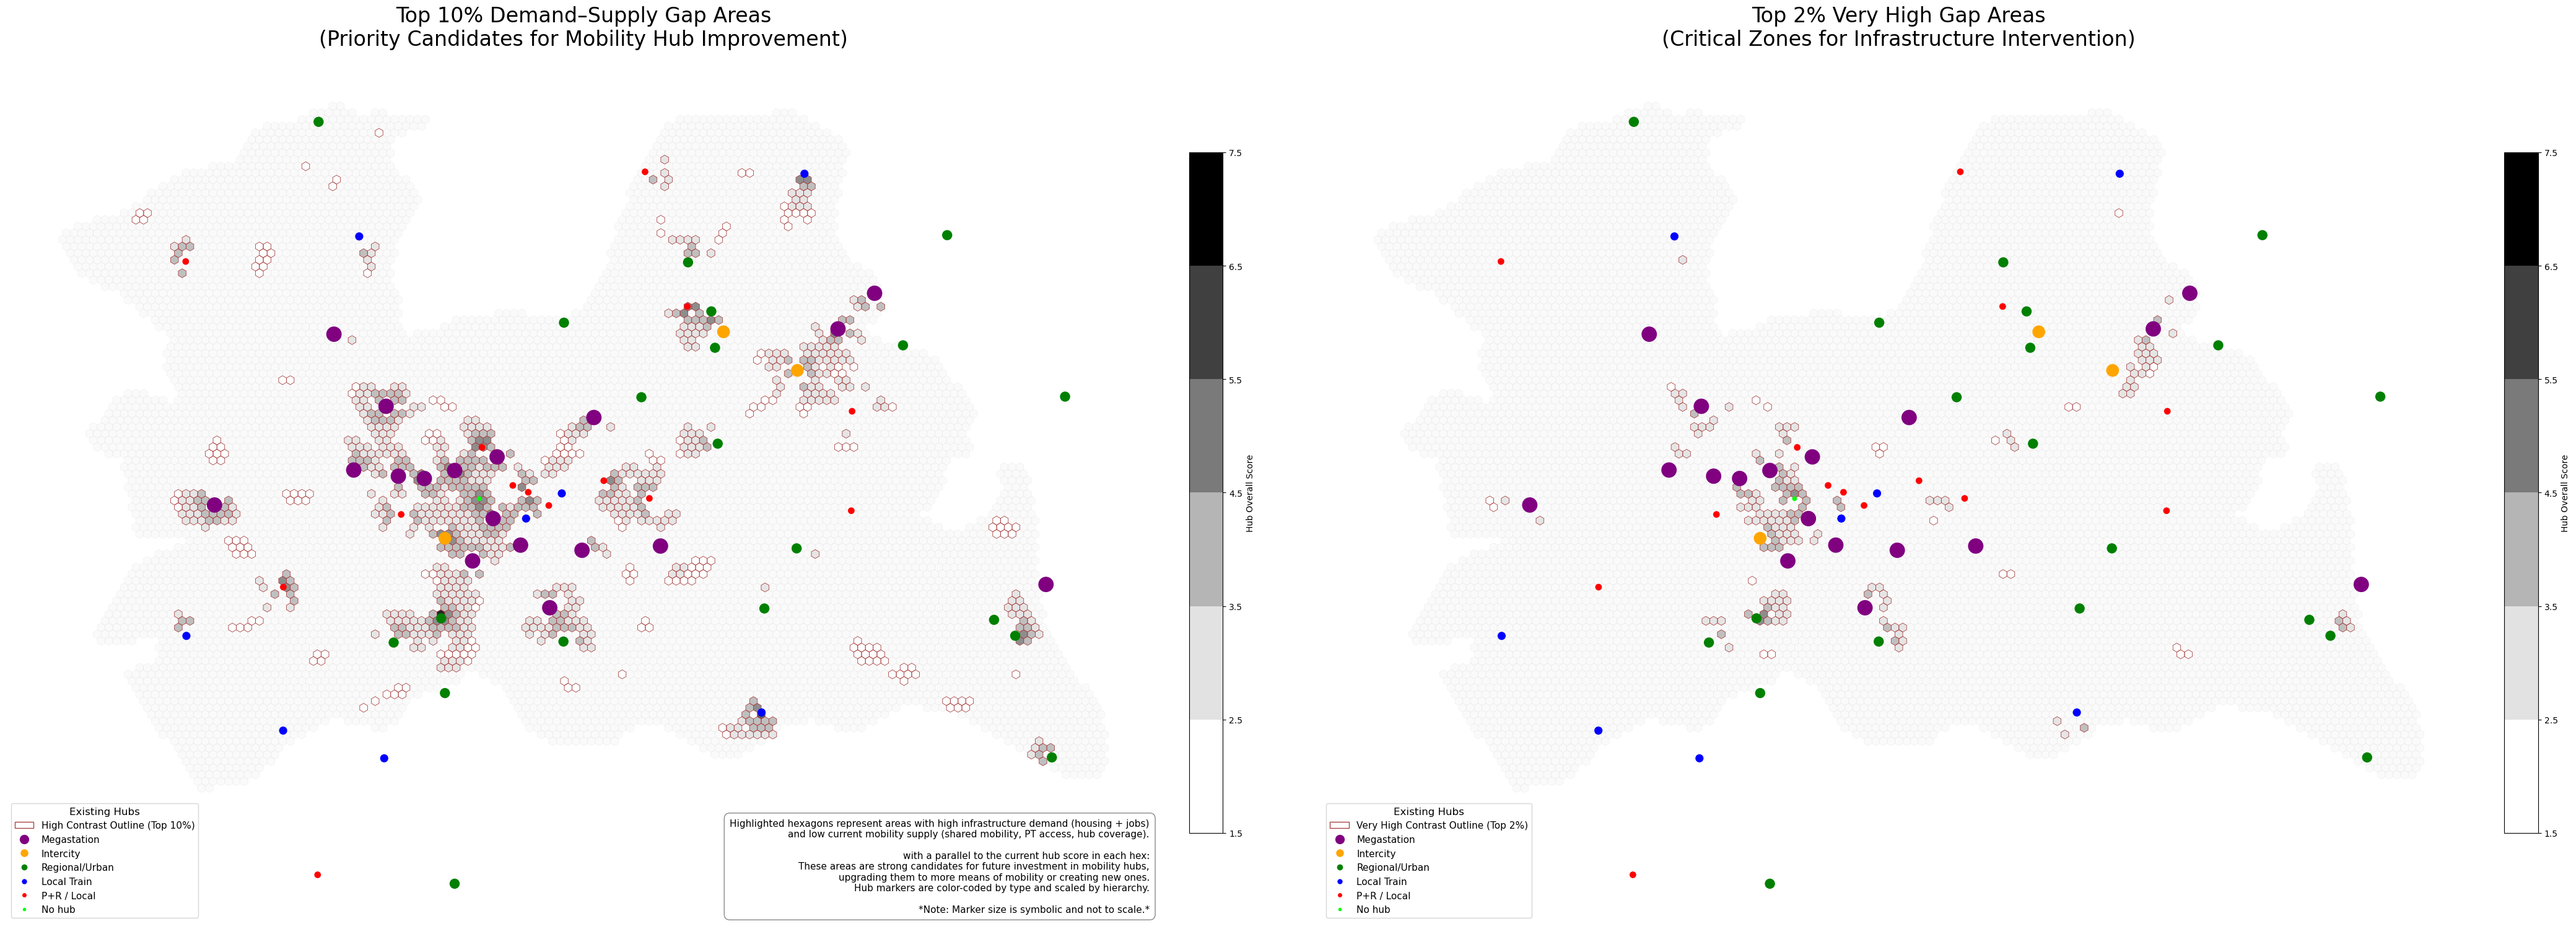

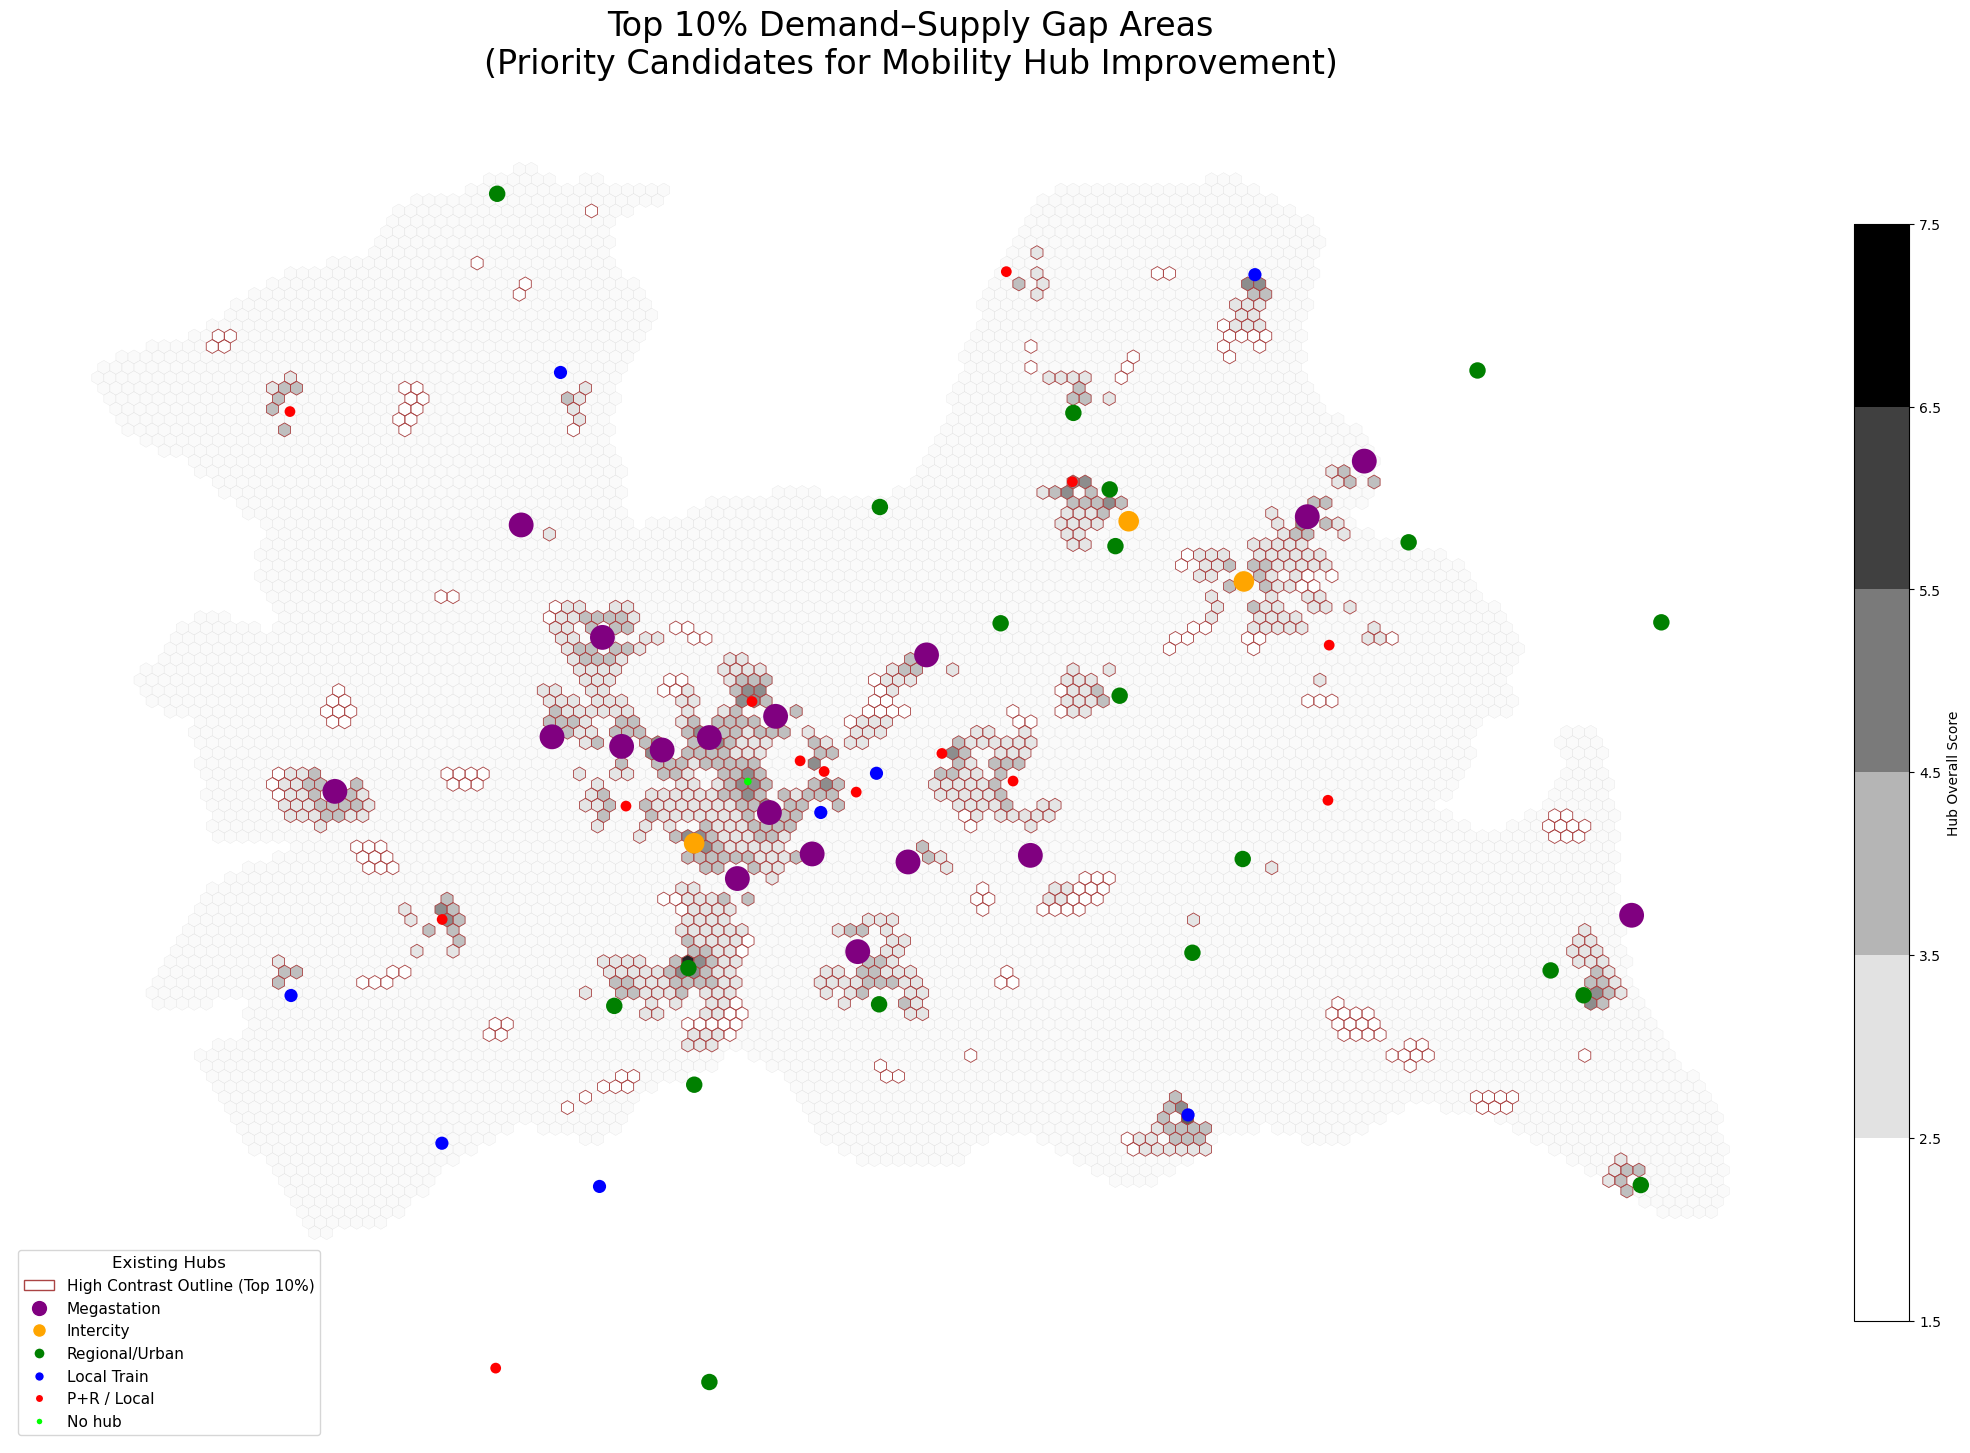

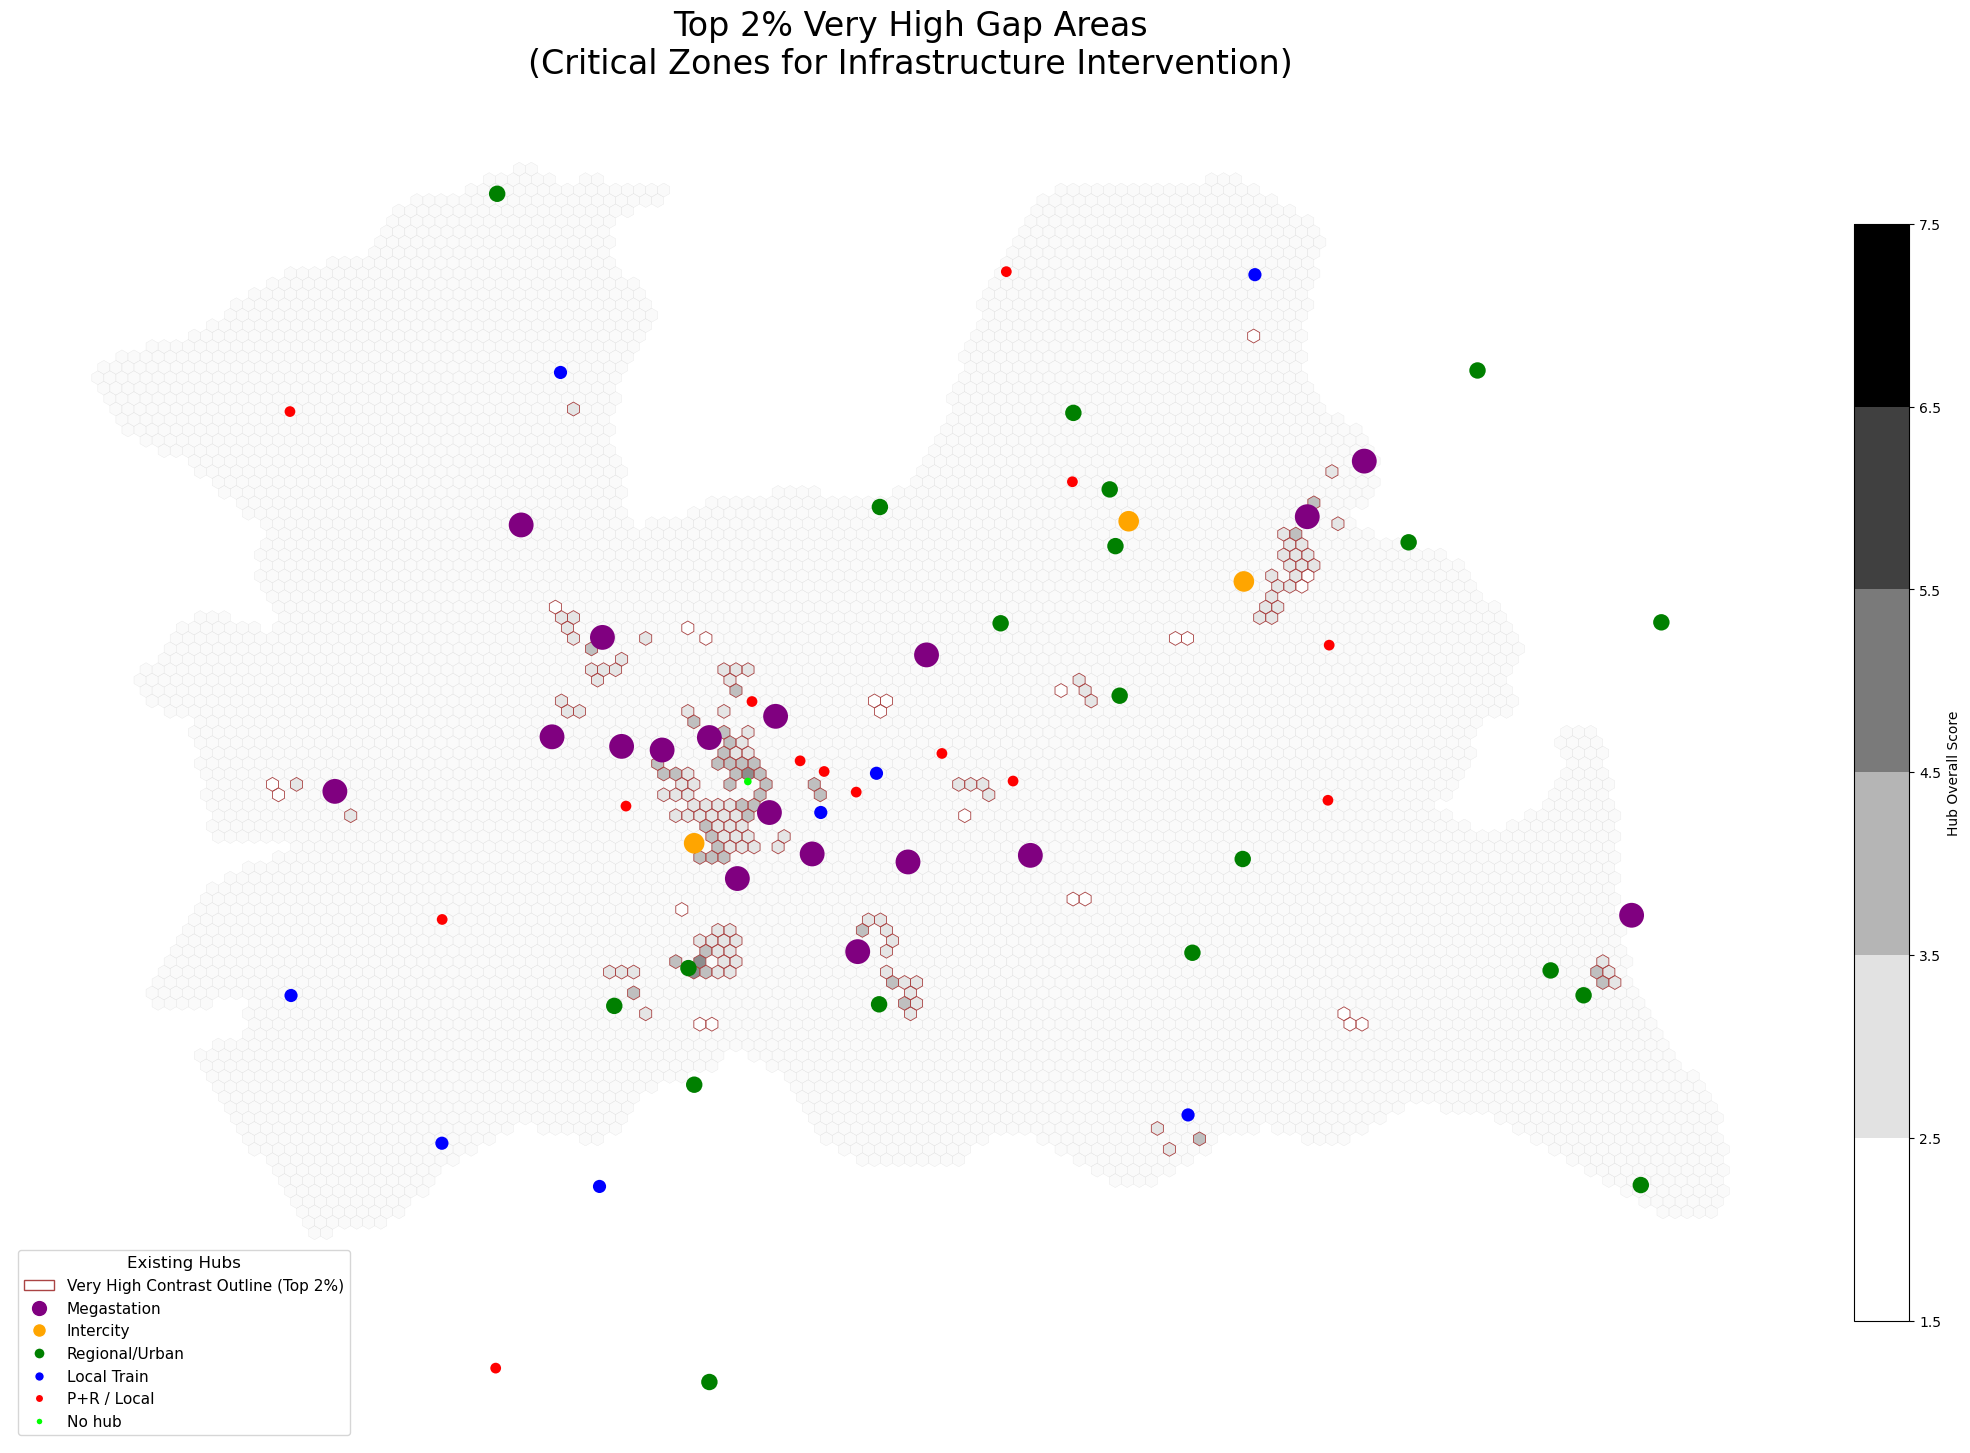

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.lines import Line2D
import os

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# --- Additional: Save the top 10% and top 2% gap hexes as GeoPackages for QGIS ---
output_dir = os.path.join("2.0_notebooks", "0.0_outputs", "mobility_hubs")
os.makedirs(output_dir, exist_ok=True)

# Save high_contrast_hexes (top 10%) and very_high_contrast_hexes (top 2%) as GeoPackages
high_contrast_gpkg_path = os.path.join(output_dir, "top_10pct_gap_areas.gpkg")
very_high_contrast_gpkg_path = os.path.join(output_dir, "top_2pct_gap_areas.gpkg")

# Remove existing files if they exist (to avoid append issues)
for gpkg_path in [high_contrast_gpkg_path, very_high_contrast_gpkg_path]:
    if os.path.exists(gpkg_path):
        os.remove(gpkg_path)

# Hub type color mapping (not used in this legend, but kept for completeness)
hub_type_colors = {
    5: "#800080",  # Megastation
    4: "#FFA500",  # Intercity
    3: "#008000",  # Regional/Urban
    2: "#0000FF",  # Local Train
    1: "#FF0000",  # P+R / Local
    0: "#00FF00",  # No hub
}

# --- Use absolute thresholds for top 10% and top 2% by count ---
n_total = len(utrecht_mobility)
n_10pct = max(1, int(np.ceil(n_total * 0.10)))
n_2pct = max(1, int(np.ceil(n_total * 0.02)))

# Sort descending by gap_score_infra
sorted_gap = utrecht_mobility.sort_values("gap_score_infra", ascending=False)

# Get top 10% and top 2% by count
high_contrast_hexes = sorted_gap.iloc[:n_10pct]
very_high_contrast_hexes = sorted_gap.iloc[:n_2pct]

# Save to GeoPackage (layer name: "top_10pct" and "top_2pct")
high_contrast_hexes.to_file(high_contrast_gpkg_path, layer="top_10pct", driver="GPKG")
very_high_contrast_hexes.to_file(very_high_contrast_gpkg_path, layer="top_2pct", driver="GPKG")

# Unique hub score values for normalization
all_unique_scores = sorted(
    set(high_contrast_hexes["hub_overall_score"].unique())
    | set(very_high_contrast_hexes["hub_overall_score"].unique())
)

cmap_greys = plt.get_cmap("Greys", len(all_unique_scores))
norm = mcolors.BoundaryNorm(
    boundaries=[x - 0.5 for x in all_unique_scores] + [all_unique_scores[-1] + 0.5],
    ncolors=len(all_unique_scores)
)

# Background masks
hexes_score_0 = utrecht_mobility[utrecht_mobility["hub_overall_score"] == 0]
hexes_score_not0 = utrecht_mobility[utrecht_mobility["hub_overall_score"] != 0]

# --- Load pictogram image for annotation ---
pictogram_path = os.path.join(output_dir, "mobility_hub_pictogram.png")
if not os.path.exists(pictogram_path):
    pictogram_path = None

def add_pictogram(ax, pictogram_path, zoom=0.18, xy=(0.97, 0.97), xycoords='axes fraction'):
    # Always try to add pictogram if path is not None
    if pictogram_path is not None and os.path.exists(pictogram_path):
        img = Image.open(pictogram_path)
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, xy, xycoords=xycoords, frameon=False, pad=0.0)
        ax.add_artist(ab)

# --- Define valid_hubs and hub_type_marker_sizes if not already defined ---
# This is a minimal fix to avoid NameError. Adjust as needed for your data.
if 'valid_hubs' not in locals():
    # Try to use hub_type_gdf if available, else create an empty GeoDataFrame
    try:
        valid_hubs = hub_type_gdf.copy()
    except NameError:
        import geopandas as gpd
        valid_hubs = gpd.GeoDataFrame()
if 'hub_type_marker_sizes' not in locals():
    hub_type_marker_sizes = {
        5: 320,  # Megastation
        4: 220,  # Intercity
        3: 140,  # Regional/Urban
        2: 90,   # Local Train
        1: 60,   # P+R / Local
        0: 30,   # No hub
    }
if 'size_legend_elements' not in locals():
    size_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Megastation', markerfacecolor=hub_type_colors[5], markersize=12),
        Line2D([0], [0], marker='o', color='w', label='Intercity', markerfacecolor=hub_type_colors[4], markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Regional/Urban', markerfacecolor=hub_type_colors[3], markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Local Train', markerfacecolor=hub_type_colors[2], markersize=7),
        Line2D([0], [0], marker='o', color='w', label='P+R / Local', markerfacecolor=hub_type_colors[1], markersize=6),
        Line2D([0], [0], marker='o', color='w', label='No hub', markerfacecolor=hub_type_colors[0], markersize=5),
    ]

# ------------------- Combined Figure (Side-by-side) -------------------
fig, axes = plt.subplots(1, 2, figsize=(44, 16))

# ---------------- LEFT: Top 10% ----------------
ax = axes[0]
hexes_score_0.plot(ax=ax, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
hexes_score_not0.plot(ax=ax, color="#f9f9f9", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)

high_contrast_hexes.plot(
    ax=ax,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0.85,
    zorder=2
)
high_contrast_hexes.boundary.plot(
    ax=ax,
    color="#aa4444",
    linewidth=0.6,
    zorder=3
)
high_contrast_hexes.iloc[[0]].plot(
    ax=ax,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0,
    legend=True,
    legend_kwds={
        "label": "Hub Overall Score",
        "orientation": "vertical",
        "shrink": 0.7,
        "pad": 0.02
    }
)
for hub_type, color in hub_type_colors.items():
    hubs_of_type = valid_hubs[valid_hubs["hub_type_score"] == hub_type]
    if not hubs_of_type.empty:
        hubs_of_type.plot(
            ax=ax,
            color=color,
            markersize=hub_type_marker_sizes[hub_type],
            marker="o",
            edgecolor="none",
            zorder=4
        )
ax.set_title(
    "Top 10% Demand–Supply Gap Areas\n(Priority Candidates for Mobility Hub Improvement)",
    fontsize=24, pad=20
)
ax.axis("off")
contrast_patch_10 = mpatches.Patch(facecolor="none", edgecolor="#aa4444", linewidth=1, label="High Contrast Outline (Top 10%)")
ax.legend(handles=[contrast_patch_10] + size_legend_elements, loc="lower left", fontsize=11, title="Existing Hubs", title_fontsize=12)

# Add pictogram to the left map
add_pictogram(ax, pictogram_path, zoom=0.18, xy=(0.97, 0.97), xycoords='axes fraction')

# ---------------- RIGHT: Top 2% ----------------
ax = axes[1]
hexes_score_0.plot(ax=ax, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
hexes_score_not0.plot(ax=ax, color="#f9f9f9", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)

very_high_contrast_hexes.plot(
    ax=ax,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0.85,
    zorder=2
)
very_high_contrast_hexes.boundary.plot(
    ax=ax,
    color="#aa4444",
    linewidth=0.6,
    zorder=3
)
very_high_contrast_hexes.iloc[[0]].plot(
    ax=ax,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0,
    legend=True,
    legend_kwds={
        "label": "Hub Overall Score",
        "orientation": "vertical",
        "shrink": 0.7,
        "pad": 0.02
    }
)
for hub_type, color in hub_type_colors.items():
    hubs_of_type = valid_hubs[valid_hubs["hub_type_score"] == hub_type]
    if not hubs_of_type.empty:
        hubs_of_type.plot(
            ax=ax,
            color=color,
            markersize=hub_type_marker_sizes[hub_type],
            marker="o",
            edgecolor="none",
            zorder=4
        )
ax.set_title(
    "Top 2% Very High Gap Areas\n(Critical Zones for Infrastructure Intervention)",
    fontsize=24, pad=20
)
ax.axis("off")
contrast_patch_2 = mpatches.Patch(facecolor="none", edgecolor="#aa4444", linewidth=1, label="Very High Contrast Outline (Top 2%)")
ax.legend(handles=[contrast_patch_2] + size_legend_elements, loc="lower left", fontsize=11, title="Existing Hubs", title_fontsize=12)

# Add pictogram to the right map
add_pictogram(ax, pictogram_path, zoom=0.18, xy=(0.97, 0.97), xycoords='axes fraction')

# ---------------- Annotation ----------------
note_text = (
    "Highlighted hexagons represent areas with high infrastructure demand (housing + jobs)\n"
    "and low current mobility supply (shared mobility, PT access, hub coverage).\n\n"
    "with a parallel to the current hub score in each hex:\n"
    "These areas are strong candidates for future investment in mobility hubs,\n"
    "upgrading them to more means of mobility or creating new ones.\n"
    "Hub markers are color-coded by type and scaled by hierarchy.\n\n"
    "*Note: Marker size is symbolic and not to scale.*"
)
axes[0].text(
    0.99, 0.01, note_text,
    transform=axes[0].transAxes,
    fontsize=11,
    va='bottom', ha='right',
    bbox=dict(boxstyle="round,pad=0.6", facecolor="white", alpha=0.92, edgecolor="grey")
)

plt.tight_layout()

output_path = os.path.join(output_dir, "very_high_gap_areas.png")
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# ------------------- Separate Figure: Top 10% Only -------------------
fig_10, ax_10 = plt.subplots(1, 1, figsize=(22, 16))
hexes_score_0.plot(ax=ax_10, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
hexes_score_not0.plot(ax=ax_10, color="#f9f9f9", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
high_contrast_hexes.plot(
    ax=ax_10,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0.85,
    zorder=2
)
high_contrast_hexes.boundary.plot(
    ax=ax_10,
    color="#aa4444",
    linewidth=0.6,
    zorder=3
)
high_contrast_hexes.iloc[[0]].plot(
    ax=ax_10,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0,
    legend=True,
    legend_kwds={
        "label": "Hub Overall Score",
        "orientation": "vertical",
        "shrink": 0.7,
        "pad": 0.02
    }
)
for hub_type, color in hub_type_colors.items():
    hubs_of_type = valid_hubs[valid_hubs["hub_type_score"] == hub_type]
    if not hubs_of_type.empty:
        hubs_of_type.plot(
            ax=ax_10,
            color=color,
            markersize=hub_type_marker_sizes[hub_type],
            marker="o",
            edgecolor="none",
            zorder=4
        )
ax_10.set_title(
    "Top 10% Demand–Supply Gap Areas\n(Priority Candidates for Mobility Hub Improvement)",
    fontsize=24, pad=20
)
ax_10.axis("off")
contrast_patch_10 = mpatches.Patch(facecolor="none", edgecolor="#aa4444", linewidth=1, label="High Contrast Outline (Top 10%)")
ax_10.legend(handles=[contrast_patch_10] + size_legend_elements, loc="lower left", fontsize=11, title="Existing Hubs", title_fontsize=12)
fig_10.tight_layout()
# Add pictogram to the individual 10% map *AFTER* tight_layout and before save
add_pictogram(ax_10, pictogram_path, zoom=0.18, xy=(0.97, 0.97), xycoords='axes fraction')
output_path_10 = os.path.join(output_dir, "top_10pct_gap_areas.png")
fig_10.savefig(output_path_10, dpi=300, bbox_inches="tight")

# ------------------- Separate Figure: Top 2% Only -------------------
fig_2, ax_2 = plt.subplots(1, 1, figsize=(22, 16))
hexes_score_0.plot(ax=ax_2, color="#f1f1f1", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
hexes_score_not0.plot(ax=ax_2, color="#f9f9f9", edgecolor="#d0d0d0", linewidth=0.2, zorder=1, alpha=0.7)
very_high_contrast_hexes.plot(
    ax=ax_2,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0.85,
    zorder=2
)
very_high_contrast_hexes.boundary.plot(
    ax=ax_2,
    color="#aa4444",
    linewidth=0.6,
    zorder=3
)
very_high_contrast_hexes.iloc[[0]].plot(
    ax=ax_2,
    column="hub_overall_score",
    cmap=cmap_greys,
    norm=norm,
    edgecolor="none",
    alpha=0,
    legend=True,
    legend_kwds={
        "label": "Hub Overall Score",
        "orientation": "vertical",
        "shrink": 0.7,
        "pad": 0.02
    }
)
for hub_type, color in hub_type_colors.items():
    hubs_of_type = valid_hubs[valid_hubs["hub_type_score"] == hub_type]
    if not hubs_of_type.empty:
        hubs_of_type.plot(
            ax=ax_2,
            color=color,
            markersize=hub_type_marker_sizes[hub_type],
            marker="o",
            edgecolor="none",
            zorder=4
        )
ax_2.set_title(
    "Top 2% Very High Gap Areas\n(Critical Zones for Infrastructure Intervention)",
    fontsize=24, pad=20
)
ax_2.axis("off")
contrast_patch_2 = mpatches.Patch(facecolor="none", edgecolor="#aa4444", linewidth=1, label="Very High Contrast Outline (Top 2%)")
ax_2.legend(handles=[contrast_patch_2] + size_legend_elements, loc="lower left", fontsize=11, title="Existing Hubs", title_fontsize=12)
fig_2.tight_layout()
# Add pictogram to the individual 2% map *AFTER* tight_layout and before save
add_pictogram(ax_2, pictogram_path, zoom=0.18, xy=(0.97, 0.97), xycoords='axes fraction')
output_path_2 = os.path.join(output_dir, "top_2pct_gap_areas.png")
fig_2.savefig(output_path_2, dpi=300, bbox_inches="tight")

# --- Add: Print summary for all top 10% and 2% hexes (by new selection) ---
# Mark the new top 10% and 2% in the main dataframe for summary
utrecht_mobility["in_10pct"] = utrecht_mobility.index.isin(high_contrast_hexes.index)
utrecht_mobility["in_2pct"] = utrecht_mobility.index.isin(very_high_contrast_hexes.index)
print_gap_summary_by_hub_score(utrecht_mobility[utrecht_mobility["in_10pct"] | utrecht_mobility["in_2pct"]])
